# TMA4320 - Project 3 #

In this project we will look at four numerical methods for solving ordinary differntial equations and apply these on the Hénon-Heiles model. The four numerical methods we will use are Shampine-Bogacki method, which has order three, Kuttas method of the fourth order, Kahans method of the second order and the Störmer-Verlet method, which is of order two. 

We will first validate the convergence orders of the methods, then we will look at energy conservation and lastly Poincarè maps. 




Here needed libraries and functions to solve the tasks are imported, together with jit which can decrease the time it takes to run the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import RK45
from scipy.integrate import solve_ivp
from matplotlib.ticker import StrMethodFormatter
import time

In [2]:
#%pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

## Implementation of the methods##

The Hénon-Heiles model, which has dimension 4, are: 

<center>$q_1'= p_1$ <center>

<center>$q_2'= p_2$<center>  
    
<div style="text-align: right"> (1) </div>

<center>$p_1'= -q_1(1+2q_2)$ <center>

<center>$p_2'=-(q_2 +q_1^2-q_2^2)$ <center>

The behavior of the system which the Hénon-Heiles model describes is dependent on the initial values. For some initial values the solution will be caotic. The initial values gives which part of the phase space the sytem is in. 
To solve the Hénon-Heiles model with the following numerical methods one need a set of initial conditions. Througout the project we will use the initial conditions described in the project description under "Numerisk prosedyre. Startverdi" on page 8. The initial conditions are $H_0=\frac{1}{12}$, $q_{0,1}=0$, $ q_{0,2}=0.45$ and $p_{0,2}=0$. These initial condition will be used to calculate the initial condition for $p_1$, by eq. 7 which are given later in this project. These initial conditions makes sure that we are in the non chaotic phase space for the Hénon-Heiles model.
    
The four numerical methods are given below as equations.

Method A: the Shampine-Bogacki method of the fourth order : 

<center>$F_1 = F(y_n) $

<center>$F_2=F(y_n+\frac{1}{2}hF_1) $

<div style="text-align: right"> (2) </div>

<center>$F_3=F(y_n+\frac{3}{4}hF_2)$

<center>$ y_{n+1}=y_n+h(\frac{2}{9}F_1+\frac{1}{3}F_2+\frac{4}{9}F_3)$

Method B: Kuttas method of the fourth order:

<center>$F_1 = F(y_n) $

<center>$F_2=F(y_n+\frac{1}{2}hF_1) $

<center>$F_3=F(y_n+\frac{1}{2}hF_2)$

<center>$F_4=F(y_n+hF_3)$
    
<div style="text-align: right"> (3) </div>

<center>$ y_{n+1}=y_n+h(\frac{1}{6}F_1+\frac{1}{3}F_2+\frac{1}{3}F_3+\frac{1}{6}F_4)$

Method C: Kahans method of the second order:

<center>$ y_i'=\sum_{j,k=1}^m a_{ijk}y_jy_k + \sum_{j=1}^m b_{ij}y_j + c_i, i=1,....,m$
    
<div style="text-align: right"> (4) </div>

<center>$ \frac{y_{i,n+1}-y_{i,n}}{h}=\sum_{j,k=1}^m a_{ijk} \frac{y_{j,n}y_{k,n+1}+y_{j,n+1}y_{k,n}}{2} + \sum_{j=1}^m b_{ij} \frac{y{j,n}+y{j,n+1}}{2} + c_i$

Method D: The Störmer-Verlet method of the second order:

<center>$p_{n+\frac{1}{2}}=p_n+\frac{1}{2}hf(q_n)$

<center>$q_{n+1}=q_n+hp_{n+\frac{1}{2}}$

<div style="text-align: right"> (5) </div>

<center>$p_{n+1}=p_{n+\frac{1}{2}}+\frac{1}{2}hf(q_{n+1})$ <center>
    
    
    
In the following codeblock the numerical methods and the Hénon-Heiles model are implemented as functions.   
 

In [3]:
# All the functions are jitted, which means that the hole function will be compiled and stored  for later use.
# Therefore the time it takes to run the code decreases.

# This function implements the Henon-Heiles model, Eq. 1.
# It takes in y which is an array with four elements, q_1,q_2, p_1 and p_2. 
# The function also takes in F_vec which is a vector who will contain the derivative values. 
# Then the derivative values are calculated according to the Henon-Heiles method which is described above. 
# The calculated values are stored in the F_vector which is defined outside this function. 
@jit(nopython=True)
def F(y,F_vec):
    F_vec[0] = y[2]
    F_vec[1] = y[3]
    F_vec[2] = -y[0]*(1+2*y[1])
    F_vec[3] = -(y[1]+y[0]**2-y[1]**2)

# This function implements the Shampine-Bogacki method, Eq. 2.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up. 
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y are set as the first element of y_vector.
# The F_vector is made with the correct length.
# The y_values are then calculated by a for loop. Inside the for loop there is first a call to the global F function which
# calculates the derivatives for q_1,q_2,p_1 and p_2 which are used to calculate F_1, F_2 and F_3. From these the 
# next y_value is found. This is the implementation of the Shampine-Bogacki method. 
# Then if h_last is different from h the calculation of F_1, F_2 and F_3 and the last y values are done using h_last 
# instead of h.
# Then the y_vector is returned. 

@jit(nopython=True)
def solve_HH_A(t_0, T,h,y_0):
    
    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n
    
    
    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
    
    y_vec[0,:] = y_0
    F_vec = np.zeros((4,3))
    
    for i in range(n):
        F(y_vec[i,:], F_vec[:,0])
        F(y_vec[i,:] + 1/2*h * F_vec[:,0], F_vec[:,1])
        F(y_vec[i,:] + 3/4*h * F_vec[:,1], F_vec[:,2])
        y_vec[i+1,:] = y_vec[i,:] + h * 1/9*(2*F_vec[:,0] + 3*F_vec[:,1]+ 4*F_vec[:,2])
    
    if h_last>0:
        F(y_vec[-2,:], F_vec[:,0])
        F(y_vec[-2,:] + 1/2*h_last * F_vec[:,0], F_vec[:,1])
        F(y_vec[-2,:] + 3/4*h_last * F_vec[:,1], F_vec[:,2])
        y_vec[-1,:] = y_vec[-2,:] + h_last * 1/9*(2*F_vec[:,0] + 3*F_vec[:,1]+ 4*F_vec[:,2])
    
    return y_vec

# This function implements Kuttas method of the fourth order, Eq. 3.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up. 
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y are set as the first element of y_vector.
# The F_vector is made with the correct length.
# The y_values are then calculated by a for loop. Inside the for loop there is first a call to the global F function which
# calculates the derivatives for q_1, q_2, p_1 and p_2 which are used to calculate F_1, F_2, F_3 and F_4.  
# From these the next y_value is found. This is the implementation of Kuttas method of the fourth order. 
# Then if h_last is different from h the calculation of F_1, F_2, F_3 and F_4 together with the last y values 
# are done using h_last instead of h.
# Then the y_vector is returned. 

@jit(nopython=True)
def solve_HH_B(t_0,T,h,y_0):

    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n

    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
    
    y_vec[0,:] = y_0
    F_vec = np.zeros((4,4))
    
    for i in range(n):
        F(y_vec[i,:], F_vec[:,0])
        F(y_vec[i,:] + 1/2*h * F_vec[:,0], F_vec[:,1])
        F(y_vec[i,:] + 1/2*h * F_vec[:,1], F_vec[:,2])
        F(y_vec[i,:] + h * F_vec[:,2], F_vec[:,3])
        y_vec[i+1,:] = y_vec[i,:] + h * 1/6*(F_vec[:,0] + 2*F_vec[:,1] + 2*F_vec[:,2] + F_vec[:,3])
    
    if h_last>0:
        F(y_vec[-2,:], F_vec[:,0])
        F(y_vec[-2,:] + 1/2*h_last * F_vec[:,0], F_vec[:,1])
        F(y_vec[-2,:] + 1/2*h_last * F_vec[:,1], F_vec[:,2])
        F(y_vec[-2,:] + h_last * F_vec[:,2], F_vec[:,3])
        y_vec[-1,:] = y_vec[-2,:] + h_last * 1/6*(F_vec[:,0] + 2*F_vec[:,1] + 2*F_vec[:,2] + F_vec[:,3])
    
    return y_vec

# This function implements Kahans method of the second order, Eq. 4.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up. 
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y is set as the first element of y_vector.
# The F_vector is made with the correct length.
# The y_values are then calculated by a for loop. Inside the for loop the values for q_1,q_2, p_1 and p_2 are found from the 
# y_vec and stored as variables. Then the b_vector and A_matrix are made with the values for q and p. 
# Then the equation A*y=b is solved for y using numpys built in function linalg.solve(), and the next element in the y_vec 
# is set equal to y. 
# This is the implementation of Kahans method of the second order. 
# Then if h_last is different from h the calculation of A, b and the last y values are done using h_last instead of h.
# Then the y_vector is returned. 

@jit(nopython=True)
def solve_HH_C(t_0,T,h,y_0):
    
    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n
    
    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
    
    y_vec[0,:] = y_0
    
    
    for i in range(n):
        q_1=y_vec[i,0]
        q_2=y_vec[i,1]
        p_1=y_vec[i,2]
        p_2=y_vec[i,3]
        b=np.array([h*p_1+2*q_1, h*p_2+2*q_2, 2*p_1-h*q_1, -h*q_2+2*p_2])
        A=np.array([[2,0,-h,0],[0,2,0,-h],[h*(2*q_2+1),2*h*q_1,2,0],[2*h*q_1,h*(-2*q_2+1),0,2]])
        
        y_vec[i+1]=np.linalg.solve(A,b)
        
    if h_last>0:
        q_1=y_vec[-2,0]
        q_2=y_vec[-2,1]
        p_1=y_vec[-2,2]
        p_2=y_vec[-2,3]
        b=np.array([h_last*p_1+2*q_1, h_last*p_2+2*q_2, 2*p_1-h_last*q_1 , -h_last*q_2+2*p_2])
        A=np.array([[2,0,-h_last,0],[0,2,0,-h_last],[h_last*(2*q_2+1),2*h_last*q_1,2,0],[2*h_last*q_1,h_last*(-2*q_2+1),0,2]])
        
        y_vec[-1]=np.linalg.solve(A,b)
        
    return y_vec


# This function implements Stormer-Verlets method of the second order, Eq. 5.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up. 
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y is set as the first element of y_vector.
# The F_vector is made with the correct length, before the global F function is called which calculates the derivatives 
# for q_1,q_2,p_1 and p_2. 
# The y_values are then calculated by a for loop. Inside the for loop p_(n+1/2) are calculated from p_1 and p_2 for n
# and p derivated values. p derivated is stored in the F_vector. Then q_1 and q_2 are calculated for n+1 from the values for 
# q_1 and q_2 for n together with h and p_(n+1/2). Then the p'_n+1 values are calculated from the F(function). 
# These values are then used to calculate p_1 and p_2 for n+1 together with h and p_(n+1/2). q_n+1 and p_n+1 equals the next y
# values. 
# This is the implementation of Stormer-Verlets method of the second order. 
# Then if h_last is different from h the calculation of A, b and the last y values are done using h_last instead of h.
# Then the y_vector is returned. 

@jit(nopython=True)
def solve_HH_D(t_0,T,h,y_0):
    
    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n

    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
        
    y_vec[0,:] = y_0
    F_vec = np.zeros(4)
    
    F(y_vec[0,:], F_vec)
    
    for i in range(n):
        p_2 = y_vec[i,2:] + 1/2 * h * F_vec[2:]
        y_vec[i+1,:2] = y_vec[i,:2] + h * p_2
        F(y_vec[i+1,:],F_vec)
        y_vec[i+1,2:] = p_2 + 1/2 * h * F_vec[2:]
        
    if h_last>0:
        p_2 = y_vec[-2,2:] + 1/2 * h_last * F_vec[2:]
        y_vec[-1,:2] = y_vec[-2,:2] + h_last * p_2
        F(y_vec[-1,:],F_vec)
        y_vec[-1,2:] = p_2 + 1/2 * h_last * F_vec[2:]
        
    return y_vec

## Phaseplots ##

This is not a mandatory part of the project, but we found phaseplots to be very useful in visualising the behaviour of our numerical methods and look at the stability of the system. The phase plots shows the coherence between $q$ and $p$, since we plot $p_1$ as a function of $q_1$ and $p_2$ as a function of $q_2$. 


The energy in Hénon-Heiles model is given by the following equation

<center>$H(q,p)=\frac{1}{2}(p_1^2+p_2^2)+\frac{1}{2}(q_1^2+q_2^2) + \lambda (q_1^2q_2-\frac{1}{3}q_2^3)$
    
<div style="text-align: right"> (6) </div>

This means that knowing the initial conditions for gievn values for $q_1, q_2$ and $p_2$, $p_1$ can be calculated by the following equation

<center>$p_1=\sqrt{2H_0-p_2^2-q_1^2-q_2^2-2q_1^2q_2+\frac{2}{3}q_2^3}$

<div style="text-align: right"> (7) </div>
    
In this project $p_1$ is not known but the others are, so $p_1$ is calculated by the eq. 7. 



In [4]:
# This function calculates p1s value based on the values for q_1, q_2, p_2 and H_0.
# The function takes in q_1, q_2,p_2 and H_0 and then returns p_1 found from the energy equation of a Hamilton system, eq. 7 
def p_1_calc(q_1,q_2,p_2,H_0):
    return np.sqrt(2*H_0-p_2**2--q_1**2-q_2**2-2*q_1**2*q_2+2/3*q_2**3)

# Here the function that calculates p1 is called with values given on page 8 in the project description,
# and the value is stored as a variable for later use
p1=p_1_calc(0.0, 0.45,0,1/12)

In [5]:
# Here we define constants for this task
t_0=0
T = 1e3
h = 1e-2
y_0=[0.0,0.45,p1,0.0]

# Here we call uopn the different methods to solve the Henon-Heiles modell, with the given values. 
y_vec_A = solve_HH_A(t_0,T,h,y_0)
y_vec_B = solve_HH_B(t_0,T,h,y_0)
y_vec_C = solve_HH_C(t_0,T,h,y_0)
y_vec_D = solve_HH_D(t_0,T,h,y_0)


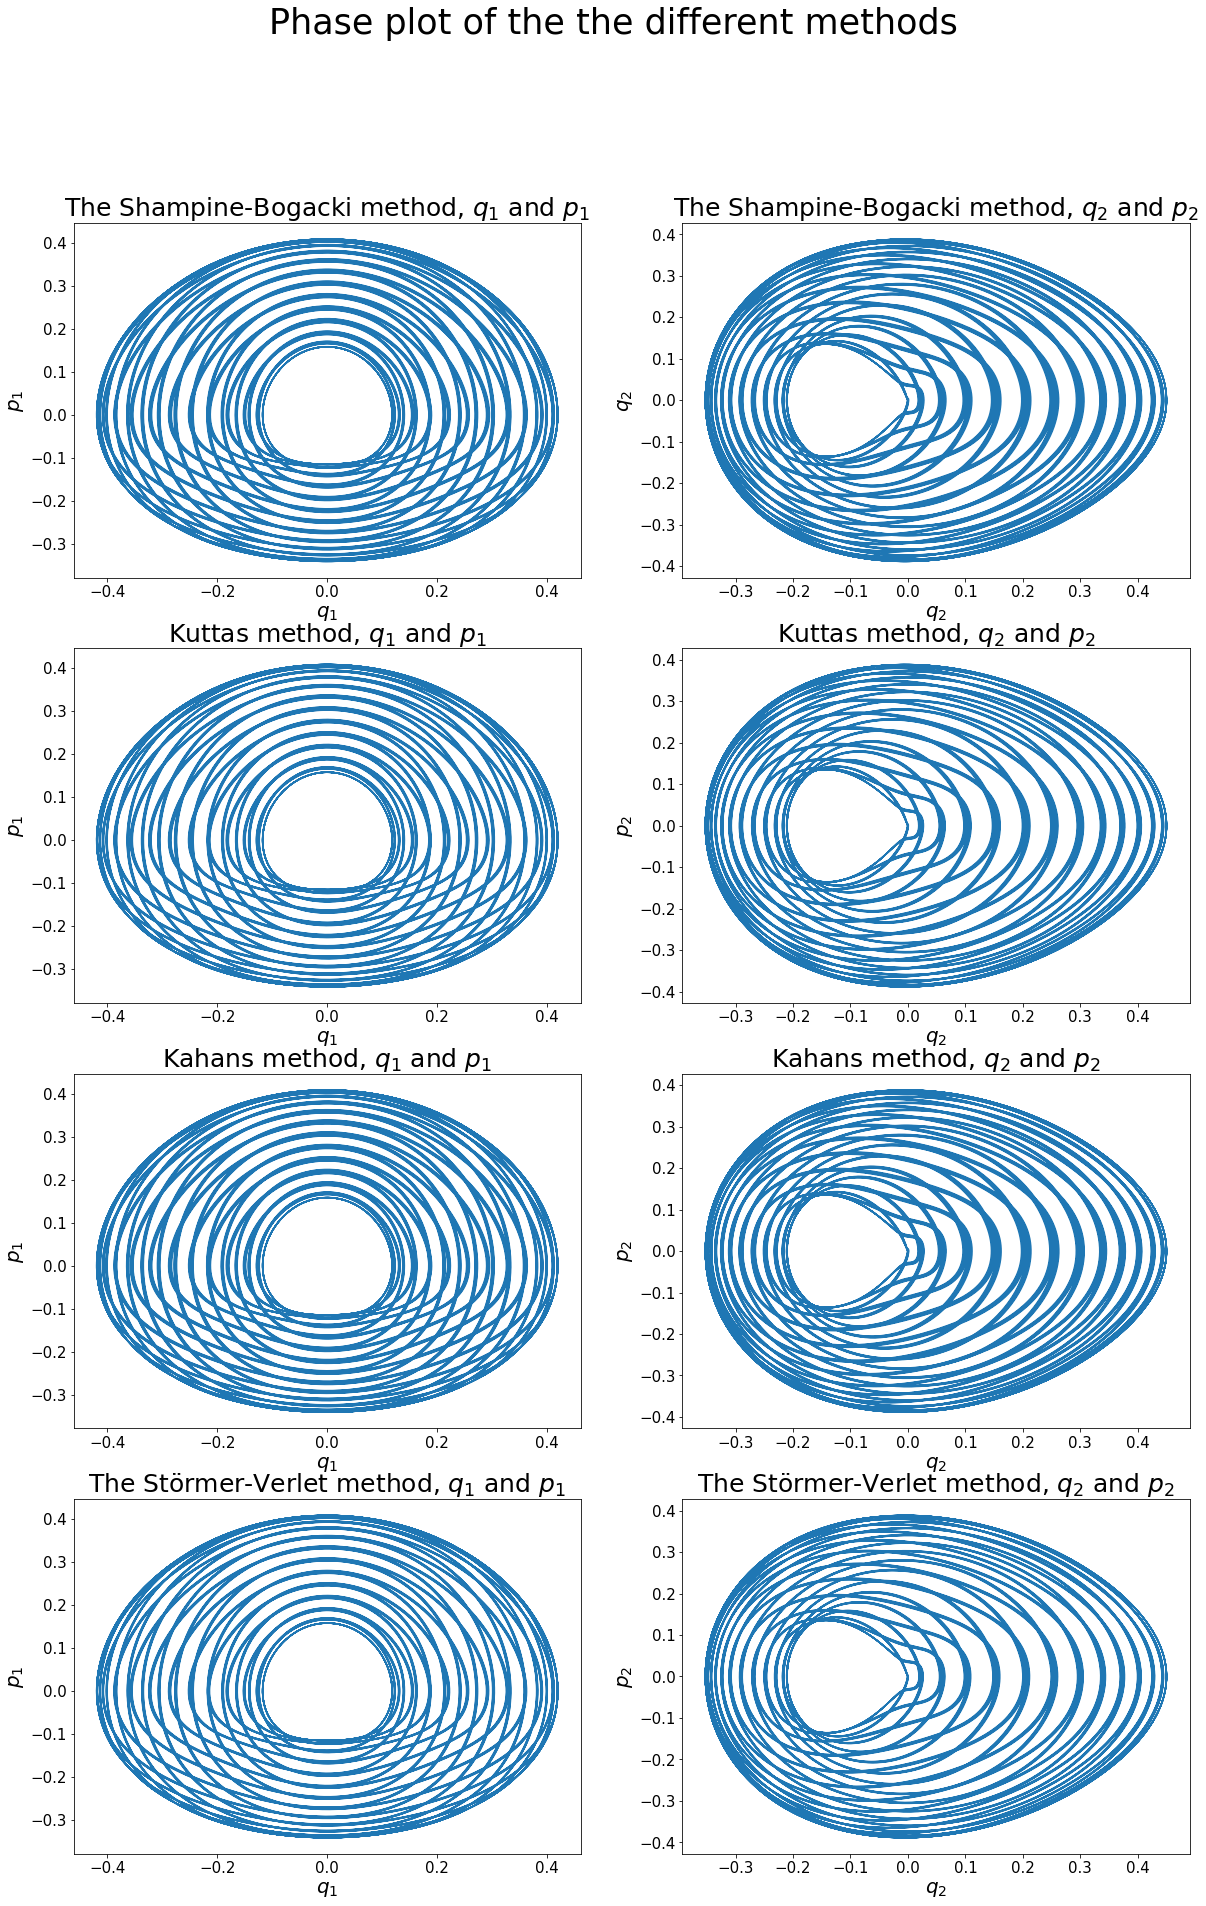

In [6]:
# Here we plot phase plots for all the methods
# First a figur is made and its specified that we want two subplots horizontaly and 4 vertcical. 
# Then the figure is given a title. 
# Since the plotcode for the different methods are identical they will be commented once.
# First the subplot is given a title. Then in the first subplot for the method p_1 are plotted as a function of q_1. 
# In the second plot for the method p_2 are plotted as a function of q_2.
# The axes are then given titles and the fontsize on the axes is set. 
# In the end a plt.show makes sure the figure is given as output. 

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 30))


fig.suptitle('Phase plot of the the different methods', fontsize=35)

ax1.set_title("The Shampine-Bogacki method, $q_1$ and $p_1$", fontsize=25)
ax1.plot(y_vec_A[:,0],y_vec_A[:,2])
ax1.set_xlabel('$q_1$', fontsize=20)
ax1.set_ylabel('$p_1$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.set_title("The Shampine-Bogacki method, $q_2$ and $p_2$", fontsize=25)
ax2.plot(y_vec_A[:,1],y_vec_A[:,3])
ax2.set_xlabel('$q_2$', fontsize=20)
ax2.set_ylabel('$q_2$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax3.set_title("Kuttas method, $q_1$ and $p_1$", fontsize=25)
ax3.plot(y_vec_B[:,0],y_vec_B[:,2])
ax3.set_xlabel('$q_1$', fontsize=20)
ax3.set_ylabel('$p_1$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)

ax4.set_title("Kuttas method, $q_2$ and $p_2$", fontsize=25)
ax4.plot(y_vec_B[:,1],y_vec_B[:,3])
ax4.set_xlabel('$q_2$', fontsize=20)
ax4.set_ylabel('$p_2$', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=15)

ax5.set_title("Kahans method, $q_1$ and $p_1$", fontsize=25)
ax5.plot(y_vec_C[:,0],y_vec_C[:,2])
ax5.set_xlabel('$q_1$', fontsize=20)
ax5.set_ylabel('$p_1$', fontsize=20)
ax5.tick_params(axis='both', which='major', labelsize=15)

ax6.set_title("Kahans method, $q_2$ and $p_2$", fontsize=25)
ax6.plot(y_vec_C[:,1],y_vec_C[:,3])
ax6.set_xlabel('$q_2$', fontsize=20)
ax6.set_ylabel('$p_2$', fontsize=20)
ax6.tick_params(axis='both', which='major', labelsize=15)

ax7.set_title(u"The St\xF6rmer-Verlet method, $q_1$ and $p_1$", fontsize=25)
ax7.plot(y_vec_D[:,0],y_vec_D[:,2])
ax7.set_xlabel('$q_1$', fontsize=20)
ax7.set_ylabel('$p_1$', fontsize=20)
ax7.tick_params(axis='both', which='major', labelsize=15)

ax8.set_title(u"The St\xF6rmer-Verlet method, $q_2$ and $p_2$", fontsize=25)
ax8.plot(y_vec_D[:,1],y_vec_D[:,3])
ax8.set_xlabel('$q_2$', fontsize=20)
ax8.set_ylabel('$p_2$', fontsize=20)
ax8.tick_params(axis='both', which='major', labelsize=15)

plt.show()


From the phaseplots we can see that $q$ and $p$ are in phase, because of the smooth closed curves in the phase plots. Since we are in a non chaotic part of the phase space for the Hénon-Heiles model this is expected. 

## Problem 1 ##

In this problem we will verify the convergence order of the different methods. To find the convergence order we find a reference solution, which can be used to find the global error. In this project the reference solution are found by scipys rutine scipy.integrate.solve_ivp which solves the given model with RK45, with strict tolerances. Then the global error is found by subtracting the referance solution from the approksimation. By plotting the error as a function of the step length we get a curve where the inclination of the curve equals the convergence order. In addition we calculate the convergence order, p, as numbers. This is done with eq. 8

<center> $ p \approx \frac{ln\frac{E(h_2)}{E(h_1)}}{ln\frac{h_2}{h_1}}$
<div style="text-align: right"> (8) </div>

In [7]:
# This function is mostly the same as the F function which we defined in the beginning of the notebook. 
# The differnce is that here we make a new F_vector in the function and then return the F_vector. 
# Otherwise the implementation of the Henon-Heiles model is the same. 
# The reason we have defined this F_ref function is because we need the function to be on this form when we use it in 
# scipy.integrate.solve_ivp(). Otherwise we want to use the F() function because this takes up less memory on the computer. 
def F_ref(t,y):
    F_vec= np.zeros((4, ))
    F_vec[0] = y[2]
    F_vec[1] = y[3]
    F_vec[2] = -y[0]*(1+2*y[1])
    F_vec[3] = -(y[1]+y[0]**2-y[1]**2)
    return F_vec

# This function calculates the global error and p value for a method. Where p is the convergence order of the method.
# The function takes in funk which is the reference function implementation of the Henon-Heiles model.
# Solve_HH is the function that solves the Henon-Heiles model for a specific method. nexps is the number of h values 
# the error is calculated for. t_0 and T is the start and end time. r and s is the start and end of the logarithmic
# h value intervall. y_0 is the initial values for y. rtol_1 and atol_1 are limits used to calculate the reference solution.
# First the function makes a list of h values with nexps elements from 10^s to 10^r. 
# Then an empty list, errors_lst, with length nexps is made. This will contain the global errors when they are calculated.
# There is also made and empty list for the p values with length nexps-1. The p_lst must be one element shorter because 
# of the way p is calculated. 
# Then a reference solution is made by calling the built in function solve_ivp. The reference solution is here used as
# a close to exact solution since Henon Heiles do not have an exact solution. 
# Then the errors for each h value is calculated by a for loop. First the solve_HH function is called with the current h 
# value, which gives y_vec as a result. 
# Then the error is calulated by subtracting the last y_values in the reference solution from the 
# last values in y_vec and taking the norm. The calculated error is stored in the errors list. 
# Then the order of the method p is calculated from eq. 8 and added to the p_lst. The reason that p is only calculated from
# 1 to n is because the previous error is subtracted from the current error. 
# Then h_lst, errors_lst and p_lst are returned. 
def check_convergence(funk, solve_HH, nexps,t_0,T,r,s,y_0,rtol_1,atol_1):
    h_lst = np.logspace(s,r,nexps)
    
    errors_lst = np.zeros(nexps)
    p_lst=np.zeros(nexps-1)
    
    ref_solution=solve_ivp(funk,(t_0,T),y_0,'RK45',rtol=rtol_1,atol=atol_1).y

    
    for i in range(nexps):
        y_vec = solve_HH(t_0,T,h_lst[i],y_0)
        errors_lst[i]=np.linalg.norm(y_vec[-1,:]-ref_solution[:,-1])
        
        if i>0:
            p=np.log(errors_lst[i]/errors_lst[i-1])/np.log(h_lst[i]/h_lst[i-1])
            p_lst[i-1]=p
    
    return h_lst, errors_lst,p_lst

In [8]:
# Here constants for this task is defined. 
# r and s is the start and end of the logarithmic h intervall
# t_0 and T is the start and end time
# rtol and atol are the tolerances for the solve_ivp function
# nexps is the number of steps in the h intervalle
# y_0 is the initial values for q_1, q_2, p_1 and p_2. 
r= 0 
s=-4
t_0=0
T=1e2
rtol=1e-14
atol=1e-14
nexps= 25
y_0=[0.0,0.45,p1,0.0]

# Here the check_convergence function is called for the 4 differenth methods and with the constants above and the returned
# values are stored.
h_lst_A, errors_A, p_A = check_convergence(F_ref,solve_HH_A,nexps,t_0,T,r,s,y_0,rtol,atol)
h_lst_B, errors_B, p_B = check_convergence(F_ref,solve_HH_B,nexps,t_0,T,r,s,y_0,rtol,atol)
h_lst_C, errors_C, p_C = check_convergence(F_ref,solve_HH_C,nexps,t_0,T,r,s,y_0,rtol,atol)
h_lst_D, errors_D, p_D = check_convergence(F_ref,solve_HH_D,nexps,t_0,T,r,s,y_0,rtol,atol)


/Users/amalietoftumhop/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


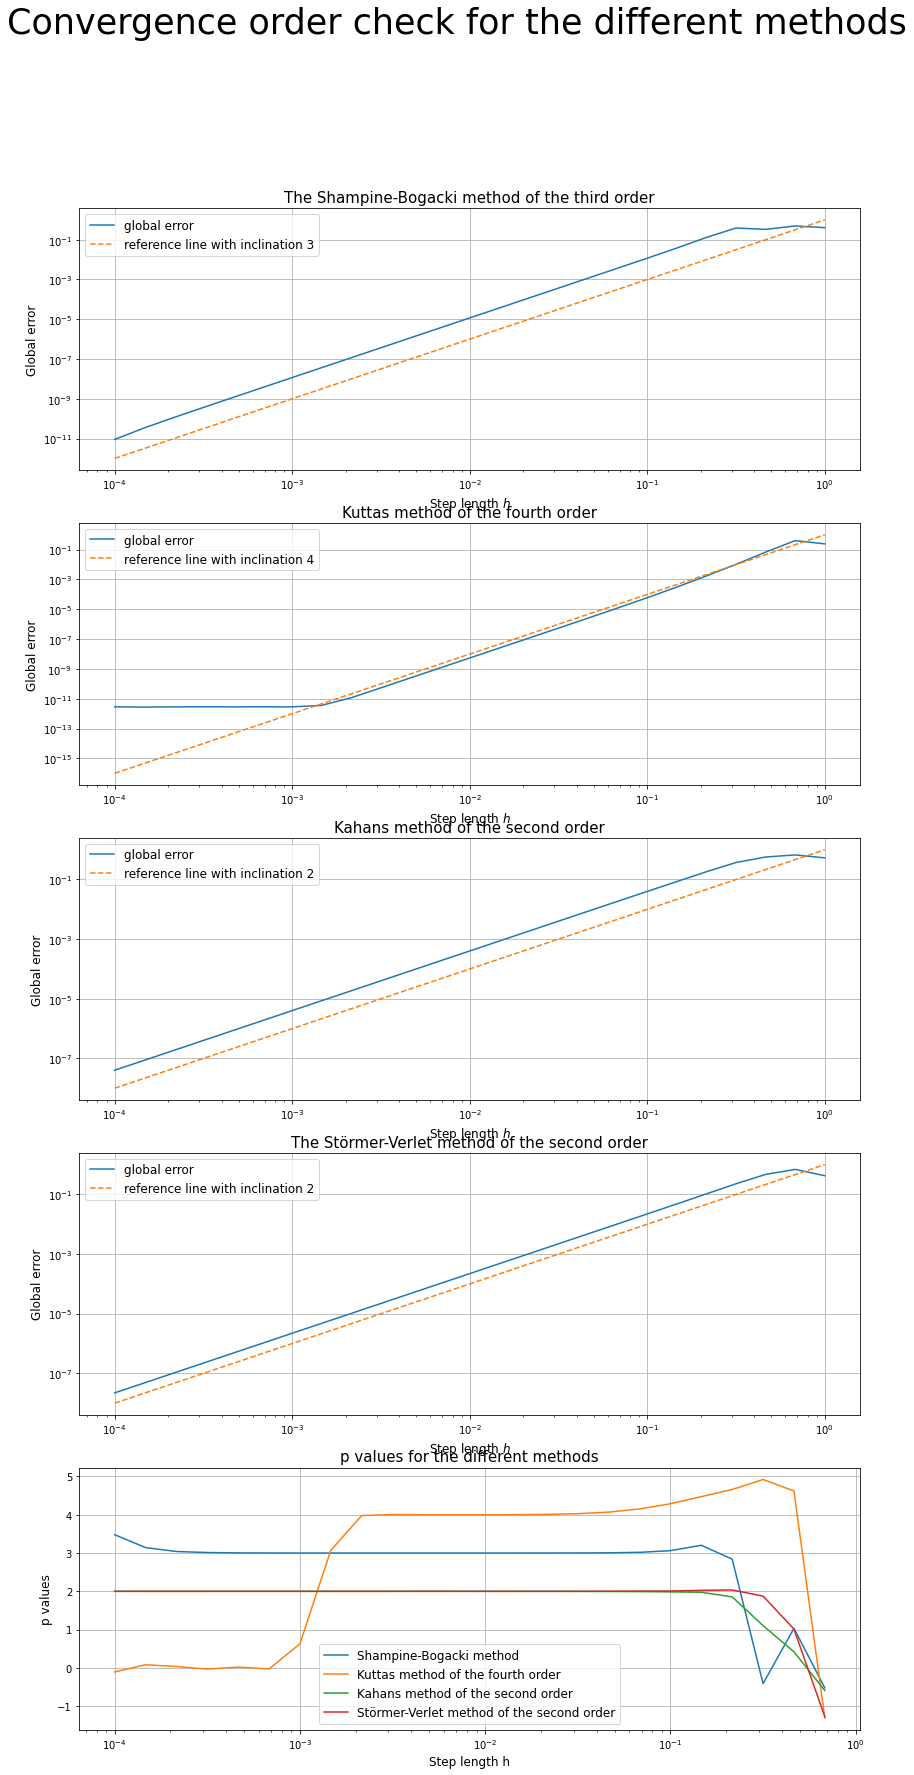

In [9]:
# Here we plot the gobal errors and orders, p, for the different methods.
# First a figure with 5 subplots is made. 
# The first four subplots are plots of the global error for each of the methods. The code for the plots are basicly identical,
# so they will be explained as one. 
# First a title is set for the subplot. 
# Then the errors is plotted as a function of h values as a loglog plot for the spesific method.
# Then a reference line with the order of the method as the inclination is plotted. 
# Then labels for the axes, a grid and a box with labels for the curves is added to the subplot.
# The fifth subplot is a plot with the p values for all the methods. This subplot is first given a title,
# then the p values are plotted as a function of h for each of the methods. 
# Then labels for the axes, a grid and a box with labels for the curves is added to the subplot.
# Lastly there is a plt. show to get the figure as output. 
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(14, 28))

plt.suptitle("Convergence order check for the different methods", fontsize=35)

ax1.set_title("The Shampine-Bogacki method of the third order", fontsize=15)
ax1.loglog(h_lst_A, errors_A, label= "global error")
ax1.loglog(h_lst_A, (h_lst_A)**3, label = "reference line with inclination 3", linestyle="--")
ax1.legend(prop = {'size':12})
ax1.set_xlabel("Step length $h$", fontsize=12)
ax1.set_ylabel("Global error", fontsize=12)
ax1.grid()

ax2.set_title("Kuttas method of the fourth order", fontsize=15)
ax2.loglog(h_lst_B, errors_B, label= "global error")
ax2.loglog(h_lst_B, (h_lst_B)**4, label = "reference line with inclination 4", linestyle="--")
ax2.legend(prop = {'size':12})
ax2.set_xlabel("Step length $h$", fontsize=12)
ax2.set_ylabel("Global error", fontsize=12)
ax2.grid()

ax3.set_title("Kahans method of the second order", fontsize=15)
ax3.loglog(h_lst_C, errors_C, label= "global error")
ax3.loglog(h_lst_C, (h_lst_C)**2, label = "reference line with inclination 2", linestyle="--")
ax3.legend(prop = {'size':12})
ax3.set_xlabel("Step length $h$", fontsize=12)
ax3.set_ylabel("Global error", fontsize=12)
ax3.grid()

ax4.set_title(u"The St\xF6rmer-Verlet method of the second order", fontsize=15)
ax4.loglog(h_lst_D, errors_D, label= "global error")
ax4.loglog(h_lst_D, (h_lst_D)**2, label = "reference line with inclination 2", linestyle="--")
ax4.legend(prop = {'size':12})
ax4.set_xlabel("Step length $h$", fontsize=12)
ax4.set_ylabel("Global error", fontsize=12)
ax4.grid()

ax5.set_title(u"p values for the different methods", fontsize=15)
ax5.semilogx(h_lst_A[:-1],p_A, label= "Shampine-Bogacki method")
ax5.semilogx(h_lst_B[:-1],p_B, label = "Kuttas method of the fourth order")
ax5.semilogx(h_lst_C[:-1],p_C, label = "Kahans method of the second order")
ax5.semilogx(h_lst_D[:-1],p_D, label = u"St\xF6rmer-Verlet method of the second order")
ax5.legend(prop = {'size':12})
ax5.set_xlabel("Step length h", fontsize=12)
ax5.set_ylabel("p values", fontsize=12)
ax5.grid()


plt.show()


From the first four plots we can see that all the curves have the same inclination as its reference line in the intervall from $10^{-3}$ to $10^{-1}$. For Shampine-Bogacki, Kahans method and Störmer-Verlet method the curves follow the reference line in the entire intervall. Kuttas method on the other hand deviates from the reference for small timesteps. This is expected since the error for this method is of several magnitudes lower than the other methods for small timesteps, which means that the limit for the precision of the reference solution is achieved. So it is actually the reference solution that leads to the near horisontal line for timesteps smaller than $10^{-3}$. In this area rounding errors may also play a role. 

This behaviour is also seen in the last plot where we look at the $p$-values for Kuttas method. We also have a small deviation for Shampine-Bogacki for timesteps near $10^{-4}$, and this is likely caused by rounding errors or the precision of the reference solution. In the last plot one can only barely see the curve for Kahans method because this curve lies behind the curve for Störmer-Verlet for $h$ lower than $10^{-1}$. 

For large values of $h$, the $p$-values are inaccurate because convergence order are based on an asymptotical premise that the step length, $h$, goes to zero. This explains that the curves for the global error in the first four plots deviates from a straight line and that the inclination decreases when the step lengths become large. In the last plot this will show as decreasing curves for all four methods and $p$ values around zero or negative. 

If we look away from the effects of the reference solution and premise for $h$, which means looking at the intervall for $h$ between $10^{-3}$ and $10^{-1}$,  we can see that all our implementations the methods have the convergence order that were given and expected. 


## Problem 2##

In this problem we will look at the numericals methods ability to preserve energy in Hamilitionian systems. The energy in Hamiltonian models is given by the following equation

<center>$H(q,p)=\frac{1}{2}(p_1^2+p_2^2)+\frac{1}{2}(q_1^2+q_2^2) + \lambda (q_1^2q_2-\frac{1}{3}q_2^3)$
<div style="text-align: right"> (9) </div>
    
We let $\lambda=1$. Eq. 9 and $\lambda=1$ are given in the project description.

In [5]:
# This function calculates the energy of a method for the different y values. 
# The function takes in t_0, T and y_vec which is a 2D arrays with values for q_1,q_2,p_1 andp_2 for the different timesteps,
# t_0 and T is the start and end time. 
# A list with the same length as y_vec is made to hold the calculated energies.
# The energy is calculated for each timestep by a for loop. The energy is calculated from eq. 9
# Then the energy_lst is returned. 
@jit(nopython=True)
def energy_func(t_0,T,y_vec):
    energy_lst=np.zeros(len(y_vec))
    for i in range(len(y_vec)):
        y=y_vec[i]
        energy_lst[i]=1/2*(y[2]**2+y[3]**2) + 1/2 * (y[0]**2+y[1]**2) + (y[0]**2*y[1]-1/3*y[1]**3)

    return energy_lst

# This function makes a t_lst with the same length as the energy_lst made by energy_func.
# The function takes in t_0, T and y_vec which is a 2D arrays with values for q_1,q_2,p_1 andp_2 for the different timesteps.
# t_0 and T is the start and end time. 
# This t_lst_func corresponds to the energy_func but we have two functions to limit the number of times the t_lst have 
# to be calculated. 
# Then the t_lst is made by a linspace and then returned. 

@jit(nopython=True)
def t_lst_func(t_0,T,len_y_lst):
    t_lst=np.linspace(t_0,T,len_y_lst) 
    return t_lst




In [11]:
# This function finds the mean energies and standard deviations for a given list of energies. 
# It takes in an energy_lst and w. w is the number of following energies the function calculates the mean of. 
# First mean_energy_lst is made which is an array with length 2 times the length of the energy_lst/w -1. 
# Then std_energy_lst which is an array with the same length as mean_energy_lst is made.
# Then the first mean and standard deviation are calculated using numpy.mean and numpy.std. with the w first elements of
# energy_lst.
# Then the rest of the means and standard deviations are calculated in a for loop. 
# The means and standard deviations are calculated in overlapping intervalls to get a more accurate result. 
# This are done by slicing the energy_lst in different ways.
# Then mean_energy_lst and std_energy_lst are returned

@jit(nopython=True)
def find_mean_of_energy(energy_lst, w):
    mean_energy_lst = np.zeros(int(len(energy_lst)/w)*2-1)
    std_energy_lst = np.zeros(len(mean_energy_lst))
    
    mean_energy_lst[0] = np.mean(energy_lst[:int(w)])
    std_energy_lst[0] = np.std(energy_lst[:int(w)])
    
    for i in range(1, len(mean_energy_lst), 2):
        k = i/2
        
        mean_energy_lst[i+1] = np.mean(energy_lst[int(k*w):int((k+1)*w)])
        mean_energy_lst[i] = np.mean(energy_lst[int(k*w-1/2*w):int(k*w+1/2*w)])
        
        std_energy_lst[i+1] = np.std(energy_lst[int(k*w):int((k+1)*w)])
        std_energy_lst[i] = np.std(energy_lst[int(k*w-1/2*w):int(k*w+1/2*w)])

    return mean_energy_lst, std_energy_lst


# This function makes a list of t values with the same length as mean_energy_lst made by the find_mean_of_energy function.
# It takes in t_lst and w.
# t_lst is a list of t values while w is the number of following energies the function calculates the mean of.
# First mean_t_lst is made which is an array with length 2 times the length of the t_lst/w -1.
# Then the first element is set as w/2.
# The rest of the t values are set by a for loop.
# Each t value corresponds to a mean value in mean_energies made by the find_mean_of_energy function.
# These functions must be called together but we have two functions to limit the number of calculations 
# and therefore the time is takes to run the code, since the mean_t_lst can be used for several methods. 
# Then the mean_t_lst is returned.

@jit(nopython=True)
def mean_t_lst_func(t_lst, w):
    mean_t_lst = np.zeros(int(len(t_lst)/w)*2-1)
    mean_t_lst[0] = t_lst[int(w/2)]
    for i in range(1, len(mean_t_lst), 2):
        k = i/2
        mean_t_lst[i] = t_lst[int(k*w)]
        mean_t_lst[i+1] = t_lst[int((k*w)+w/2)]
        
    return mean_t_lst

In [12]:
# This function calls the solve_HH, and energy_func as well as the corresponding t function for the four methods 
# and returns the results.
# The function takes t_0 and T which is the start and end time, h, the step length. y_0 the initial conditions for y.
# The solve_HH and energy_func are called for all the methods.
# Then the t_function are called.
# The t_lst, energy_lsts are returned.

@jit(nopython=True)
def get_energy_values_func(t_0, T, h, y_0):
    
    y_lst_A = solve_HH_A(t_0,T,h,y_0)
    energy_A = energy_func(t_0,T,y_lst_A)

    y_lst_B = solve_HH_B(t_0,T,h,y_0)
    energy_B = energy_func(t_0,T,y_lst_B)

    y_lst_C = solve_HH_C(t_0,T,h,y_0)
    energy_C = energy_func(t_0,T,y_lst_C)

    y_lst_D = solve_HH_D(t_0,T,h,y_0)
    energy_D = energy_func(t_0,T,y_lst_D)
    
    t_lst = t_lst_func(t_0,T,len(y_lst_A))

    return t_lst, energy_A, energy_B, energy_C, energy_D


# This function calculates the mean energies and standard deviations as well as the corresponding t function. 
# It takes in a t_lst, which is a list of t values, energies for method C an D, which are Kahans method and Stormer_verlet,
# and window_in_tems_of_T which is the timespan the means are calculated for
# First window which is the number of following elements the function calculates the mean of are found.
# Then find_mean_of_energy are called for both the methods.
# Then a t lst is made by calling mean_t_lst_func.
# mean_t_lst are returned together with the means and standard deviations for both methods
def get_mean_and_std_func(t_lst, h, energy_C, energy_D, window_in_terms_of_T):
    window = window_in_terms_of_T/h
    
    mean_energy_C, std_energy_C = find_mean_of_energy(energy_C, int(window))
    mean_energy_D, std_energy_D = find_mean_of_energy(energy_D, int(window))
    mean_t_lst = mean_t_lst_func(t_lst, window)
    
    return  mean_t_lst, mean_energy_C, mean_energy_D, std_energy_C, std_energy_D


In [13]:
# Here we define constans for this task.
H_0 = 1/12
t_0 = 0
p1 = p_1_calc(0.0, 0.45,0, H_0)
y_0 = [0.0,0.45,p1,0.0]

T_static = 1e3
T_lt = 1e6                       #lt at the end for "long time"

h_static = 1e-2

In [14]:
# Here the get_energy_values_func and get_mean_and_std_func are called with, t_0, T_static, h_static, y_0,
# energy_C, energy_D and T_static/10 as parameters. 

# The variables are defined above.
t_lst, energy_A, energy_B, energy_C, energy_D = get_energy_values_func(t_0, T_static, h_static, y_0)
mean_t_lst, mean_energy_C, mean_energy_D, std_energy_C, std_energy_D = get_mean_and_std_func(t_lst, h_static, energy_C, energy_D, T_static/10)


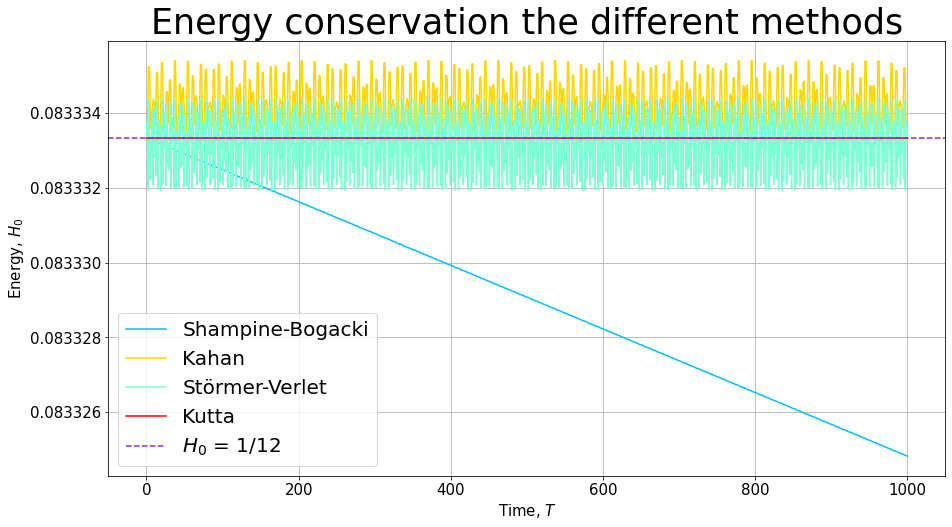

In [15]:
plt.figure(figsize=(15,8))
plt.title('Energy conservation the different methods', fontsize=35)
plt.plot(t_lst, energy_A, color='deepskyblue', label =  "Shampine-Bogacki")
plt.plot(t_lst, energy_C,  color='gold', label= "Kahan")
plt.plot(t_lst, energy_D, color='aquamarine', label= u"St\xF6rmer-Verlet")
plt.plot(t_lst, energy_B, color='r', label= "Kutta")
plt.axhline(H_0, color = "blueviolet", linestyle="--", label = f"$H_0$ = 1/12")
plt.legend(prop = {'size':20})
plt.xlabel("Time, $T$", fontsize=15)
plt.ylabel("Energy, $H_0$", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

Here we have plotted the energy as a function of time for all the methods. From the plot we can see that the curve for Shampine-Bogacki drifts a lot in comparison to the others, which means that it has a bigger energy loss. It looks like the graph for Kuttas method are parallel to $H_0$, which would mean no energy loss. As we will see in the next plot this is not the case. The curves for Kahans method and the Störmer-Verlet method both oscillate a lot, but does not seem to loose energy. Neither the Kahans metod nor Störmer-Verlet method seem to oscillate around $H_0$, but rather another close value to $H_0$, where the latter method is closer. 

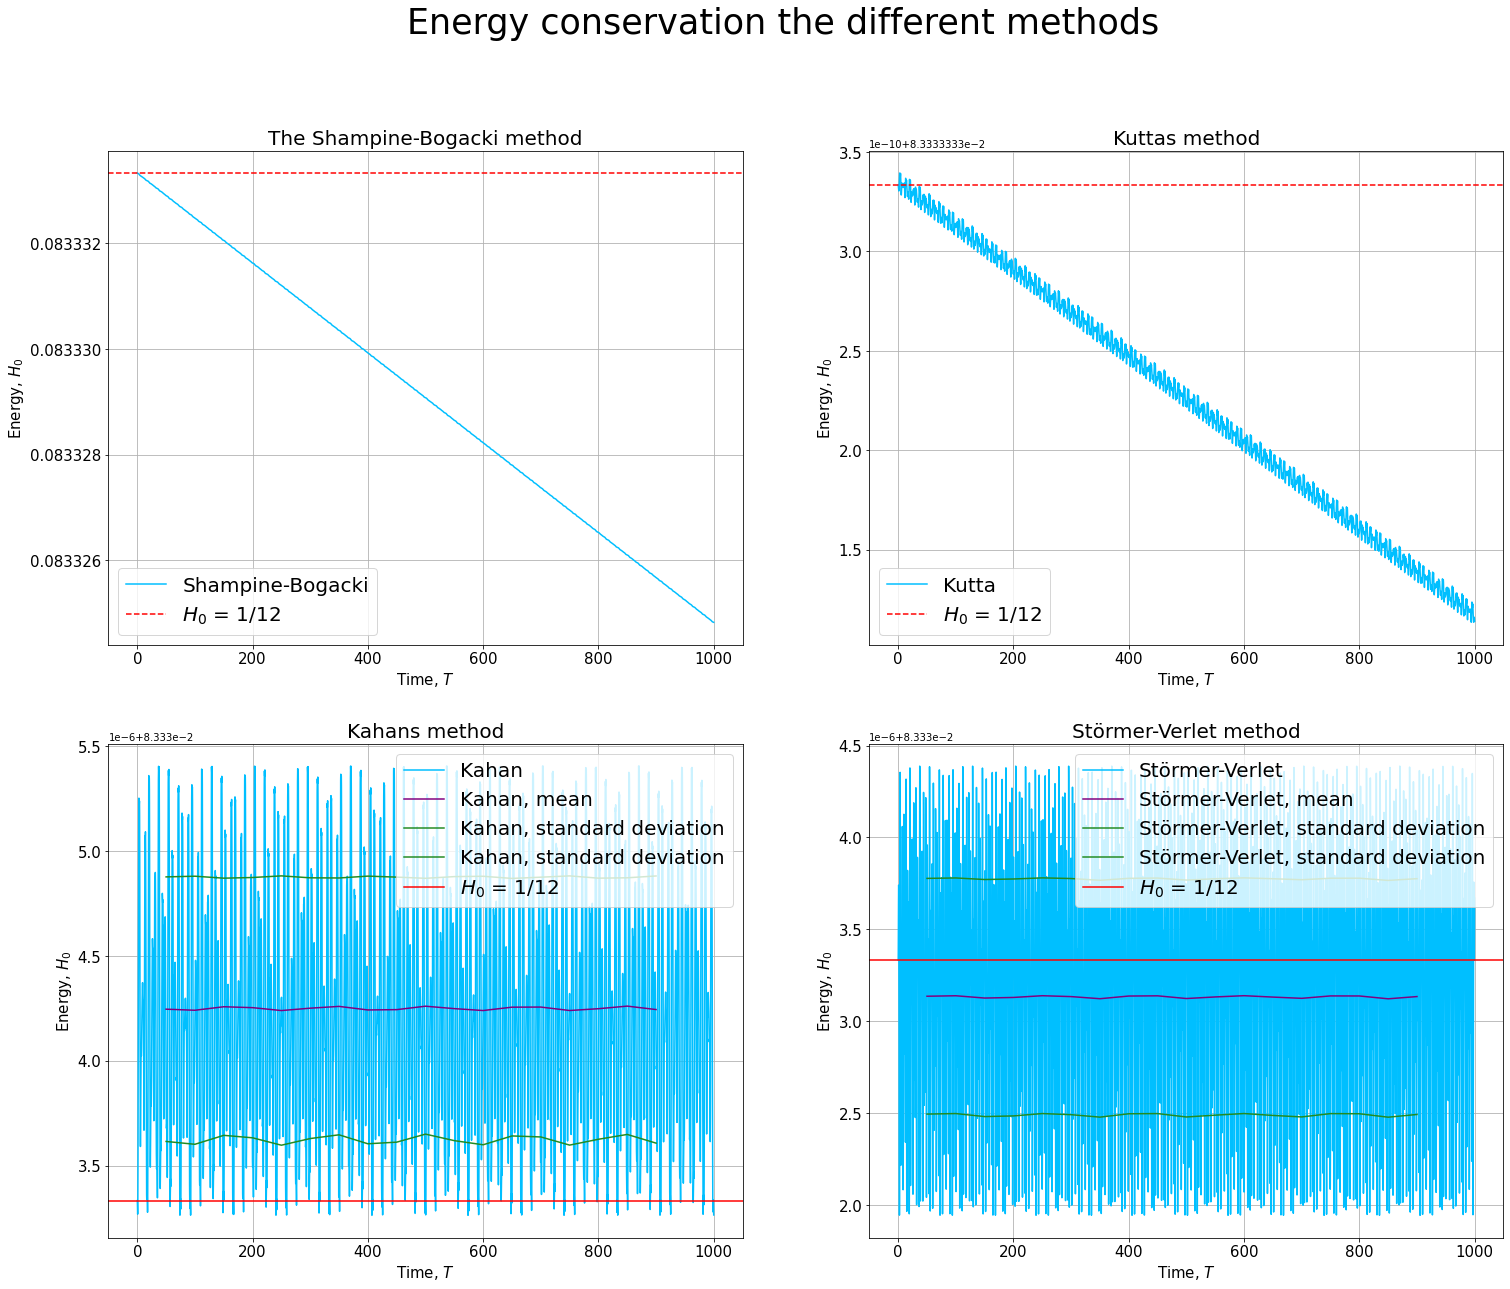

In [16]:
# Here we plot the energies as a function of time. 
# First a figur is made, given a size and the position of the subplots are defined. 
# Each subplot are the energy for one method plotted as a function of time. 
# Each subplot is given a title. Then the energies are plotted as a function of time, and a straight horizontal line 
# with value 1/12 are plotted. This is the theoretical energy value.
# For method C and D which is Kahans method and Stormer_verlet the mean energies and standar deviations are plotted as well. 
# Each curve is given a label, which are shown in the plot because of plt.legend().
# Then the axes are labeled and we add a grid to each subplot. 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(25, 20))

fig.suptitle('Energy conservation the different methods', fontsize=35)

ax1.set_title("The Shampine-Bogacki method", fontsize=20)
ax1.plot(t_lst, energy_A, color='deepskyblue', label =  "Shampine-Bogacki")
ax1.axhline(H_0, color = "r", linestyle="--", label = f"$H_0$ = 1/12")
ax1.legend(prop = {'size':20})
ax1.set_xlabel("Time, $T$", fontsize=15)
ax1.set_ylabel("Energy, $H_0$", fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid()

ax2.set_title("Kuttas method", fontsize=20)
ax2.plot(t_lst, energy_B, color='deepskyblue', label= "Kutta")
ax2.axhline(H_0, color = "r", linestyle="--", label = f"$H_0$ = 1/12")
ax2.legend(prop = {'size':20})
ax2.set_xlabel("Time, $T$", fontsize=15)
ax2.set_ylabel("Energy, $H_0$", fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid()

ax3.set_title("Kahans method", fontsize=20)
ax3.plot(t_lst, energy_C,  color='deepskyblue', label= "Kahan")
ax3.plot(mean_t_lst, mean_energy_C, color='purple',label =  "Kahan, mean")
ax3.plot(mean_t_lst, mean_energy_C+std_energy_C, color='forestgreen', label =  "Kahan, standard deviation")
ax3.plot(mean_t_lst, mean_energy_C-std_energy_C, color='forestgreen', label =  "Kahan, standard deviation")
ax3.axhline(H_0,  color='r', label = f"$H_0$ = 1/12")
ax3.legend(prop = {'size':20})
ax3.set_xlabel("Time, $T$", fontsize=15)
ax3.set_ylabel("Energy, $H_0$",fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.grid()

ax4.set_title(u"St\xF6rmer-Verlet method", fontsize=20)
ax4.plot(t_lst, energy_D, color='deepskyblue', label= u"St\xF6rmer-Verlet")
ax4.plot(mean_t_lst, mean_energy_D, color='purple', label =  u"St\xF6rmer-Verlet, mean")
ax4.plot(mean_t_lst, mean_energy_D+std_energy_D, color='forestgreen', label =  u"St\xF6rmer-Verlet, standard deviation")
ax4.plot(mean_t_lst, mean_energy_D-std_energy_D, color='forestgreen', label =  u"St\xF6rmer-Verlet, standard deviation")
ax4.axhline(H_0, color = "r", label = f"$H_0$ = 1/12")
ax4.legend(prop = {'size':20})
ax4.set_xlabel("Time, $T$", fontsize=15)
ax4.set_ylabel("Energy, $H_0$", fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.grid()

plt.show()

From the energy plots above we can see how good the different methods are at perserving energy. The Shampine-Bogacki method drifts as the time goes which means that this method will lose energy with time. 

The energy for Kuttas method will also drift as the time goes, but the energy loss for Kuttas method is very small compared to Shampine-Bogacki. The y axis for Kuttas method is scaled so the energy loss over the total timeinterval $T$ is of magnitude $10^{-10}$ for Kuttas method, while it is of magnitude $10^{-5}$ for Shampine-Bogacki. In other words, Kuttas method is a lot better at perserving energy than the Shampine-Bogacki method which is expected since Kuttas method is of the fourth order and Shampine-Bogacki is of the third order. Since both Shampine-Bogacki and Kuttas method are Runge-Kutta methods one can compare them based on convergence order, which was studied in Problem 1, and would therefore expect that Kuttas method is better at preserving energy because of the higher order, just as we have observed here. 

For Kahans method and the Störmer-Verlet method the energies oscillate a lot, which is why we have calculated and plotted the mean and standard deviation of the energies. From the mean value we can see that both these methods are very good at preserving energy even for long periods of time, which we will look closer at below. For the Störmer-Verlet method this is expected because it is a symplectic method[1]. A symplectic method means that the solution to our problem is an exact solution of a perturbed model, not the Hénon-Heiles model itself. In this case the perturbed model will also be a Hamiltonian model. The perturbed model is similar and lies very close to the Hénon-Heiles model. This implies that the energy plotted, which is the energy of the perturbed model, is very close to the energy in the Hénon-Heiles model. From the plot we can see that the mean values of the energies lies quite close to $H_0$, and $H_0$ is inside the intervall given by the standard deviation. So for Störmer-Verlet the energy of the perturbed model is quite close to the actual energy of the Hénon-heiles model.


Kahans method is not symplectic but a perturbed model is exact preserved along the numerical method, which means that Kahans method also can be said to be good at preserving energy in this case. The perturbed model for Kahans method is here a modified Hamiltonian: 
$ H'(x):=H(x)+\frac{1}{3}h\nabla H(x)^T(I-\frac{1}{2} h f'(x))^{-1}f(x)$ [2]

This means that Kahans method solves this perturbed model and its energy exact, not the Hénon-Heiles model. This explains why H_0 is outside the intervall given by the standard deviation for Kahans method. So Kahans method can here said to be energy conserving but the energy it conserves is not the actual energy of the Hénon- Heiles model. 


In conclusion we can say that it looks like Störmer-Verlet and Kahans method are energy perserving for long time  intervals but they perserve the energy of perturbed models. Note that due to the oscillations in both methods,  the energy is not preserved at all points, however the the mean energy is rather preserved. The perturbed model for Störmer-Verlet lies closer than the perturbed model for Kahans method, which gives that in this case the Störmer-Verlet method might be better. 


To compare Kuttas method to Kahans and Störmer-Verlet, one can look at the energy loss for Kuttas method and compare it to the standard deviation for Kahans and Störmer-Verlet. The standard deviation are closely connected to the magnitude of the oscillation. More specific, if the standard deviation is small, the energy loss at at given time is more likely to be smaller compare to if the standard deviation were to be larger. If one for a given time calculates the difference between the energy and the mean energy at that time using for example the Störmer-Verlet method, there is a probability that this difference will be greater than the energy loss using Kuttas method. Equivalent, if the energy loss for Kuttas method is smaller than the standard deviation, this probability will increase, and if the energy loss for Kuttas method is bigger than the standard deviation, the probability will decrease. This means that for given time one might get that Störmer-Verlet or Kahans method will have lost more energy than Kuttas method because of the fluctuations in Störmer-Verlet and Kahans methods. Note that that this is especially important for short time intervals $T$ where the energy loss of Kutta is very small compared to the standard deviation or/and the magnitude of the energy ocillations to Kutta and Störmer-Verlet. In other words, for short time intervalls there is a very high probability that for a given time, the energy loss of Kutta is smaller than the energy loss of both Kutta and Störmer-Verlet. 

The same comparison can be done between the Shampine-Bogacki method and Kahans and Störmer-Verlet methods. The difference is that the energy loss for the Shampine-Bogacki method quickly will become larger than the standard deviation for Kahans and Störmer-Verlet, which we have verified below. With quickly we mean that it takes a short time, and therefore this comparison are not that interesting if we are interested in low energy loss for long periods of time. 


To conclude we can say that Kuttas method is better at preserving energy than Shampine-Bogacki, but neither method is energy preserving. Störmer-Verlet and Kahans method preserve the energy of perturbed models over a very long time interval. If one compares Kuttas method or Shampine-Bogacki to Störmer-Verlet or Kahans method one must keep in mind the fluctuations in the two latter which might give unrealistic result if one look only at one time. 


(This may have been a little complicated and confusing discussion, but we wanted to make clear that for Kahans method and the Störmer-Verlet method, the energy ocillates, and so does the energy loss. However the mean energy is conserved for long time intervals.)

In [17]:
# Here the get_energy_values_func  and get_mean_and_std_func are called with, t_0,T_lt,h_static, y_0, energy_C, 
# energy_D and T_lt/10 as parameters. 
# The variables are defined above.
t_lt_lst, energy_A_lt, energy_B_lt, energy_C_lt, energy_D_lt = get_energy_values_func(t_0, T_lt, h_static, y_0)
mean_t_lt_lst, mean_energy_C_lt, mean_energy_D_lt, std_energy_C_lt, std_energy_D_lt = get_mean_and_std_func(t_lt_lst, h_static, energy_C_lt, energy_D_lt, T_lt/10)



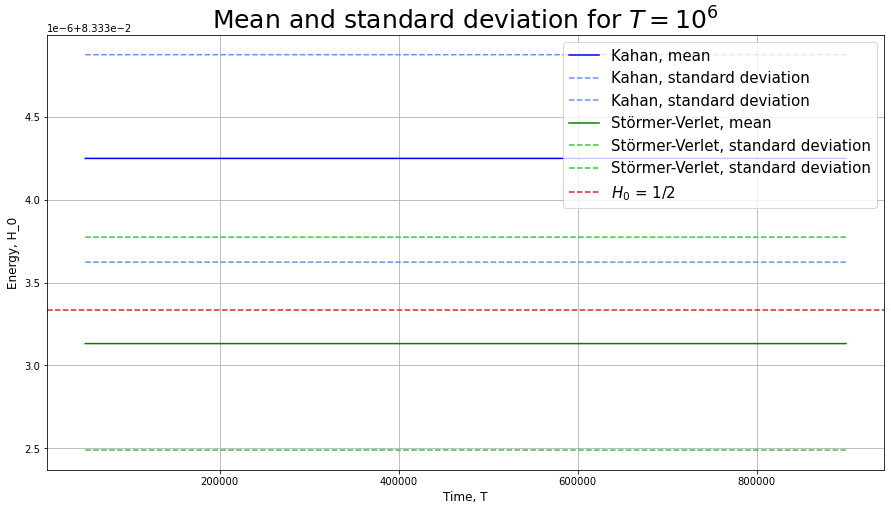

In [18]:
# Here the mean energies and standard deviations are plotted as a function of time for Kahans method 
# and the Störmer-Verlet method 
plt.figure(figsize = [15,8])
plt.title("Mean and standard deviation for $T=10^6$",  fontsize=25)
plt.plot(mean_t_lt_lst, mean_energy_C_lt, color='b', label = "Kahan, mean")
plt.plot(mean_t_lt_lst, mean_energy_C_lt+std_energy_C_lt, color='cornflowerblue', linestyle='--', label = "Kahan, standard deviation")
plt.plot(mean_t_lt_lst, mean_energy_C_lt-std_energy_C_lt, color='cornflowerblue', linestyle='--', label = "Kahan, standard deviation")
plt.plot(mean_t_lt_lst, mean_energy_D_lt, color='g', label = u"St\xF6rmer-Verlet, mean")
plt.plot(mean_t_lt_lst, mean_energy_D_lt+std_energy_D_lt, color='limegreen', linestyle='--', label = u"St\xF6rmer-Verlet, standard deviation")
plt.plot(mean_t_lt_lst, mean_energy_D_lt-std_energy_D_lt, color='limegreen', linestyle='--', label = u"St\xF6rmer-Verlet, standard deviation")
plt.axhline(H_0, linestyle="--", color = "C3", label = f"$H_0$ = 1/2")
plt.legend(prop = {'size':15})
plt.xlabel("Time, T", fontsize=12)
plt.ylabel("Energy, H_0", fontsize=12)
plt.grid()
plt.show()




Here the mean energy and standard deviation for the Störmer-Verlet method and Kahans method plotted for a longer period of time, $T = 10^6$ . From the plot we can see that the mean energy and standard deviations stay constant, which means that for $T$ up to $10^6$ the two methods are good at perserving the mean energy.

However, remark that since Störmer-Verlet is a symplectic method, it cannot preserve energy exact [3], a similiar kind of argument can be used for Kahans method too.



In [19]:
# This function calcuates the energy difference between the theoretical value and last energy value for different h.
# This is done for all methods. 
# The function takes in start and end time t_0 and T, h_lst which is a list of h_values and y_0 which is the initial
# values for y. 
# First six arrays are made with the same length as h_lst. These will contain the enrgy difference for the methods, as well 
# as the standard deviation for method C and D.
# Then a for loop calculates the energy difference for the given h value by first calling get_energy_values _func and 
# get_mean_and_std_func, with the h value. 
# Then the energy differences are calculated by taking the first element of each energy list and subtracting the last.
# Then the standard deviations are appended into the std_timestep_lists. 
# The energy_diff lists and std_timestep lists are returned.


def energy_diff(t_0, T, h_lst, y_0):
    energy_diff_A = np.zeros(len(h_lst))
    energy_diff_B = np.zeros(len(h_lst))
    energy_diff_C = np.zeros(len(h_lst))
    energy_diff_D = np.zeros(len(h_lst))
    
    std_timestep_C = np.zeros(len(h_lst))
    std_timestep_D = np.zeros(len(h_lst))
    
    for i in range(len(h_lst)):
        t_lst, energy_A, energy_B, energy_C, energy_D = get_energy_values_func(t_0, T, h_lst[i], y_0)
        mean_t_lst, mean_energy_C, mean_energy_D, std_energy_C, std_energy_D = get_mean_and_std_func(t_lst, h_lst[i], energy_C, energy_D, T/10)
        
        energy_diff_A[i] = abs(energy_A[0]-energy_A[-1])
        energy_diff_B[i] = abs(energy_B[0]-energy_B[-1])
        energy_diff_C[i] = abs(energy_C[0]-energy_C[-1])
        energy_diff_D[i] = abs(energy_D[0]-energy_D[-1])
        
        std_timestep_C[i] = np.mean(std_energy_C)
        std_timestep_D[i] = np.mean(std_energy_D)
        
    return energy_diff_A, energy_diff_B, energy_diff_C, energy_diff_D, std_timestep_C, std_timestep_D

In [20]:
#Here we define constants for this task.  
H_0 = 1/12
t_0 = 0
p1 = p_1_calc(0.0, 0.45,0, H_0)
y_0 = [0.0,0.45,p1,0.0]

r_h = 0
s_h = -3
nexps_h = 4
h_dynamic_lst = np.logspace(s_h,r_h,nexps_h)

T_dynamic_lst = [1e1, 1e3, 1e5]


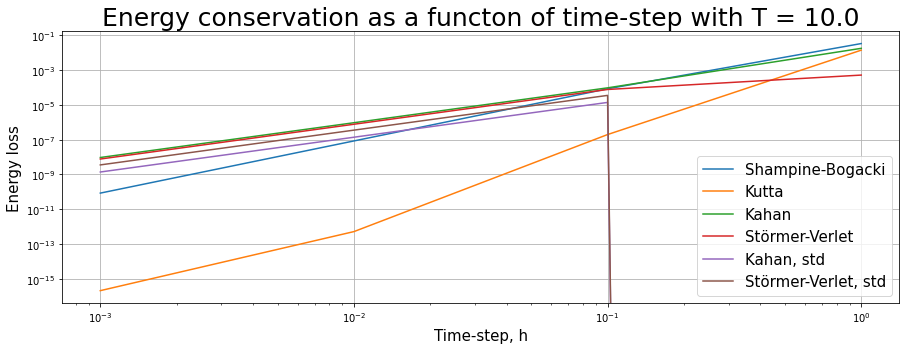

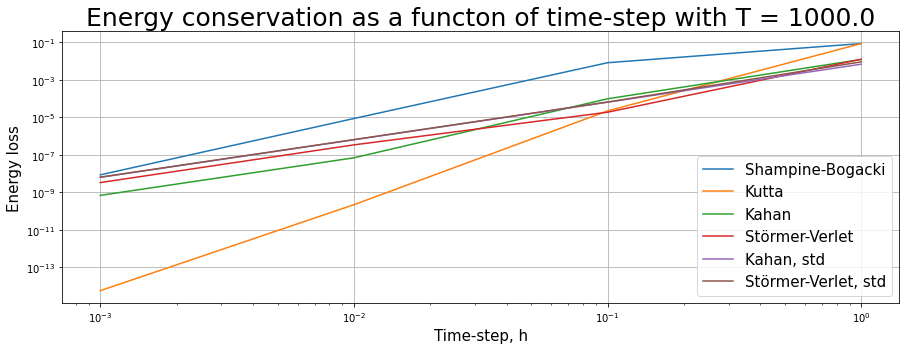

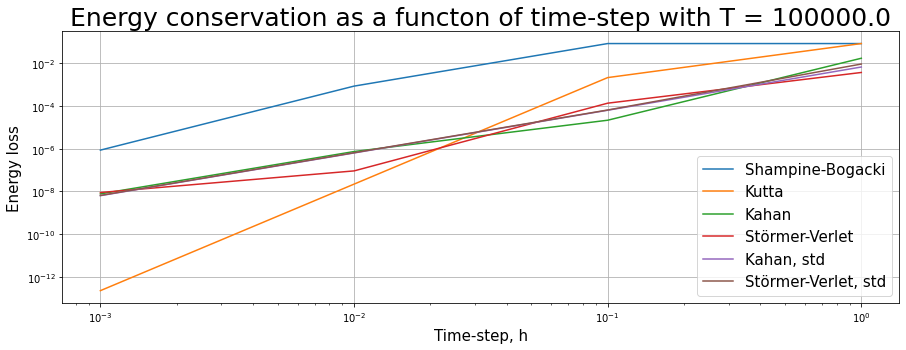

In [21]:
# This for loop iterates through the T_dynamic_lst 
# For each t value the energy_diff function is called. 
# Then the resulting energy differences and std_timestep are plotted as a function of h_dymanic_lst in loglog plots.
# The for loop gives one plot for each time value. 
for i in range(len(T_dynamic_lst)):
    energy_diff_A, energy_diff_B, energy_diff_C, energy_diff_D, std_timestep_C, std_timestep_D = energy_diff(t_0, T_dynamic_lst[i], h_dynamic_lst, y_0)

    plt.figure(figsize = [15, 5])
    plt.title(f"Energy conservation as a functon of time-step with T = {T_dynamic_lst[i]}", fontsize=25)
    plt.loglog(h_dynamic_lst, energy_diff_A, label =  "Shampine-Bogacki")
    plt.loglog(h_dynamic_lst, energy_diff_B, label =  "Kutta")
    plt.loglog(h_dynamic_lst, energy_diff_C, label =  "Kahan")
    plt.loglog(h_dynamic_lst, energy_diff_D, label =  u"St\xF6rmer-Verlet")
    plt.loglog(h_dynamic_lst, std_timestep_C, label =  "Kahan, std")
    plt.loglog(h_dynamic_lst, std_timestep_D, label =  u"St\xF6rmer-Verlet, std")
    plt.legend(prop = {'size':15})
    plt.xlabel("Time-step, h", fontsize=15)
    plt.ylabel("Energy loss", fontsize=15)
    plt.grid()

    plt.show()

In the plots above we can see how the energy conservation variates both as a function of timesteps and time interval. The energy differences which are plotted above is the differences between the theoretical energy value, $H_0=\frac{1}{12}$, and the resulting energy for the timestep when the simulation has run for the set time interval. From the plots one can see that no matter how long time interval we run the simulation, the energy differences increases with the timestep. In other words smaller timesteps means less energy loss when the simulation is run for the same time interval. This is expected behaviour, and we see the same behavior for all three time intervals plotted. 

The time we run the simulation affects the energy difference for the Shampine-Bogacki method and Kuttas method. This is expected because these methods loses energy over time. In the first plot when we run for $T=10s$ the curves for Shampine-Bogacki and Kutta, for the most part lies below the curves for Kahans method and the Störmer-Verlet method. This is in compliance with what we discussed earlier in the task; that if the time is short enough, the ocilliations to Kuttas and Störmer-Verlet energy will be greater than the energy loss for Kutta and Shampine-Bogacki. This especially holds for lower $h$, as the energy loss becomes smaller with the step length $h$ as shown here and discussed in the lectures.

When the simulation is run for a longer period of time Shampine-Bogacki will go from lying below to lying above Kahans and Störmer-Verlet. For the Shampine-Bogacki method this means that for a longer timeperiod the energy loss for this method will always be greater than for Kahans method and the Störmer-Verlet method in the timestep intervall we have chosen. From the discussion abowe, we then know that for all of these timesteps, the energy loss in Shampine-Bogacki will always be greater than the energy ocillations in Kahan and Störmer-Verlet. 

The curve for Kuttas method will cross the curves for Kahans method and the Störmer-Verlet method from below to above. We notice that the intersection of Kuttas method with Kahans method and the Störmer-Verlet method happens at a lower timestep as the time interval increases. When the simulation is run for a longer period of time the energy loss for Kuttas method will be greater than the standard deviation of oscillations for Kahans and Störmer-Verlet, and therefore most likely, at a given time $t$ close to $T$, greater than the oscillations for Kahans and Störmer-Verlet. In the last plot when $T=10^5$ this happens for $h\approx10^{-1.5}$ against for $h\approx10^{-0.5}$ in the secod plot where $T=10^4$. When the curve for Kuttas is above the curve for the standard deviation of Kahans and Störmer-Verlet the energy difference for Kuttas is most likely larger than the ocsillations for Kahans and Störmer-Verlet. If the simulation is run for a very long time we would expect that the energy differnce for Kuttas method is larger than the oscillations for Kahans and Störmer-Verlet for all timesteps. 

For Kuttas method the behaviour of the curve with time shows an increase of the energy loss. However, notice that even for $T=100000$, the Kuttas method still have a smaller energy loss the standard deviation for Kahans method and Störmer-Verlet when the step lengths are small. In other words, Kuttas methods conserves energy quite well, especially for small timesteps. On the other hand for a really long time, the energy loss in Kuttas method will grow bigger than the ocillations of of both Kahans method and the Störmer-Verlet method, and the latters will give an energy loss less then Kahan for a given $t$ close to $T$.

Kahans method and the Störmer-Verlet method dose not change much when we increase our timeintervall, as expected and discussed in the other plots above. The energy difference and standard deviations vary little with time because Kahans and Störmer-Verlet are close to energy conserving in the time intervall we run our simulations. However, the energy difference decreases with a decreasing timestep. This is the results of the ocillations, and therefore also the standard deviation, decreasing as the $h$ is getting smaller.

(Notice that in the plots the standard deviation of the Störmer-Verlet method and Kahans methos are on top of each other, creating a mixed color.)

Notice also that in this task we have used the standard deviation to say something about the magnitude of the ocillations. The bigger the standard deviation is the bigger the ocillation is. This is not exactly right but is a rough estimate that says something about the energy loss at a given time $t$ and lets us easier compare the methods. 

## Problem 3 ##

In this task we will study the Poincarè maps for the different methods. A Poincarè map is made by looking at the points where the solution of a differential equation, which is a curve in $\mathbb{R}^m$, crosses a subspace of a lower dimension. For the Hènon-Heiles model $m=4$ and we will look at the subspace on the form $(0, q_2,p_1,p_2)$. To find the points where the solution curve crosses the subspace from a given set of initial values one finds where $p_1>0$ and $q_1 $ swithes from negative to positive or positive to negative. Then using linear interpolation one can find $q_2,p_1$ and $p_2$ where $q_1=0$. $H_0$ is set to $\frac{1}{12}$.


We have chosen to make new functions, one for each method, that solves and then calculates the crosspoints between the solution curve and the subspace instead of using the functions that solves the model for the methods and then make a function that finds the crosspoints from an y_vec. The reasons behind this choice are that we will save memory in the computer because there are less crosspoints than values in the y vectors. So instead of making an y vector and saving all the values we only have to save the values for the crosspoints. We also tested methods with the built in time function and found that our implementation was faster. This effect is barely noticable when we run simulation for short periods of time, but makes a different for longer periods. The downside to our choice is that the code is a lot longer, and more difficult to read, but we decided that the amount of time we saved was worth it. 

In [7]:
# This function finds the crossing points for the Poincarè sections for the Shampine-Bogacki method, Eq. 2.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps are calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up.
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y is set as the first element of y_vector.
# The F_vector is made with the correct length.
# Two empty lists are made one for q_2 values and one for p_2 values. 
# The y_values are then calculated by a for loop. Inside the for loop there is first a call to the global F function which
# calculates the derivatives for q_1,q_2,p_1 and p_2 which are used to calculate F_1, F_2 and F_3. From these the 
# next y_value is found. This is the implementation of the Shampine-Bogacki method. 
# The first derivatives and y_1 are calculated before the for loop so that the for loop can run from 1. This is done
# to avoid an if sentence in the for loop which would have increased running time. 
# The q_2 and p_2 values of the crossing points are found as follows:
# The values for q_1, q_2, p_1 and p_2 are found for the current and previous t values. 
# Then an if sentence checks if both p_1 and p_1_prev is below zero, if they are the continue means that the function 
# goes to the next iteration in the loop.
# If one do not go to the next iteration there is another if sentence which checks if q_1 and q_1_prev has opposite signs.
# If they have the p_1 value is interpolated. 
# Then another if sentence checks if the interpolated p_1 is above zero, if it is the values for q_2 and p_2 are 
# interpolated and then appended to the lists. 
# All interpolation done here is linear interpolation. This is the end of the for loop. 
# Then if h_last is different from h the calculation of F_1, F_2 and F_3 and the last y values are done using h_last 
# instead of h, and the calculation for crosspoints are done for the last value. 
# Then q_2_lst and p_2_lst are returned as arrays. 

@jit(nopython=True)
def solve_HH_A_Poincarè(t_0, T,h,y_0):
    
    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n
    
    
    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
    
    y_vec[0,:] = y_0
    F_vec = np.zeros((4,3))
         
    q_2_lst=[]
    p_2_lst=[]
    
    F(y_vec[0,:], F_vec[:,0])
    F(y_vec[0,:] + 1/2*h * F_vec[:,0], F_vec[:,1])
    F(y_vec[0,:] + 3/4*h * F_vec[:,1], F_vec[:,2])
    y_vec[1,:] = y_vec[0,:] + h * 1/9*(2*F_vec[:,0] + 3*F_vec[:,1]+ 4*F_vec[:,2])
    
    for i in range(1,n):
        F(y_vec[i,:], F_vec[:,0])
        F(y_vec[i,:] + 1/2*h * F_vec[:,0], F_vec[:,1])
        F(y_vec[i,:] + 3/4*h * F_vec[:,1], F_vec[:,2])
        y_vec[i+1,:] = y_vec[i,:] + h * 1/9*(2*F_vec[:,0] + 3*F_vec[:,1]+ 4*F_vec[:,2])
        
        q_1= y_vec[i,0]
        q_1_prev=y_vec[i-1,0]
        q_2= y_vec[i,1]
        q_2_prev=y_vec[i-1,1]
        p_1=y_vec[i,2]
        p_1_prev=y_vec[i-1,2]
        p_2=y_vec[i,3]
        p_2_prev=y_vec[i-1,3]
        
        if (p_1<=0 and p_1_prev<=0):
            continue
        if(q_1*q_1_prev<0):
            
            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)
            
            if(p_1_i>0):
                
                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
        
    
    if h_last>0:
        F(y_vec[-2,:], F_vec[:,0])
        F(y_vec[-2,:] + 1/2*h_last * F_vec[:,0], F_vec[:,1])
        F(y_vec[-2,:] + 3/4*h_last * F_vec[:,1], F_vec[:,2])
        y_vec[-1,:] = y_vec[-2,:] + h_last * 1/9*(2*F_vec[:,0] + 3*F_vec[:,1]+ 4*F_vec[:,2])
        
        q_1= y_vec[-1,0]
        q_1_prev=y_vec[-2,0]
        q_2= y_vec[-1,1]
        q_2_prev=y_vec[-2,1]
        p_1=y_vec[-1,2]
        p_1_prev=y_vec[-2,2]
        p_2=y_vec[-1,3]
        p_2_prev=y_vec[-2,3]
            
        if(q_1*q_1_prev<0):
            
            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)
            
            if(p_1_i>0):
                
                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
    

    return np.array(q_2_lst),np.array(p_2_lst)

# This function finds the crossing points for the Poincarè sections for Kuttas method og the forth order, Eq. 3.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up.
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y is set as the first element of y_vector.
# The F_vector is made with the correct length.
# Two empty lists are made one for q_2 values and one for p_2 values. 
# The y_values are then calculated by a for loop. Inside the for loop there is first a call to the global F function which
# calculates the derivatives for q_1,q_2,p_1 and p_2 which are used to calculate F_1, F_2, F_3 and F_4. From these the 
# next y_value is found. This is the implementation of Kuttas method. 
# The first derivatives and y_1 are calculated before the for loop so that the for loop can run from 1. This is done
# to avoid an if sentence in the for loop which would have increased running time. 
# The q_2 and p_2 values of the crossing points are found as follows:
# The values for q_1, q_2, p_1 and p_2 are found for the current and previous t values. 
# Then an if sentence checks if both p_1 and p_1_prev is below zero, if they are the continue means that the function 
# goes to the next iteration in the loop.
# If one do not go to the next iteration there is another if sentence which checks if q_1 and q_1_prev has opposite signs.
# If they have the p_1 value is interpolated. 
# Then another if sentence checks if the interpolated p_1 is above zero, if it is the values for q_2 and p_2 are 
# interpolated and then appended to the lists. 
# All interpolation done here is linear interpolation. This is the end of the for loop. 
# Then if h_last is different from h the calculation of F_1, F_2, F_3 and F_4 and the last y values are done using h_last 
# instead of h, and the calculation for crosspoints are doen for the last value. 
# Then q_2_lst and p_2_lst are returned as arrays. 


@jit(nopython=True)
def solve_HH_B_Poincarè(t_0, T,h,y_0):

    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n

    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
    
    y_vec[0,:] = y_0
    F_vec = np.zeros((4,4))
    
    q_2_lst=[]
    p_2_lst=[]
    
    F(y_vec[0,:], F_vec[:,0])
    F(y_vec[0,:] + 1/2*h * F_vec[:,0], F_vec[:,1])
    F(y_vec[0,:] + 1/2*h * F_vec[:,1], F_vec[:,2])
    F(y_vec[0,:] + h * F_vec[:,2], F_vec[:,3])
    y_vec[1,:] = y_vec[0,:] + h * 1/6*(F_vec[:,0] + 2*F_vec[:,1] + 2*F_vec[:,2] + F_vec[:,3])

    for i in range(1,n):
        F(y_vec[i,:], F_vec[:,0])
        F(y_vec[i,:] + 1/2*h * F_vec[:,0], F_vec[:,1])
        F(y_vec[i,:] + 1/2*h * F_vec[:,1], F_vec[:,2])
        F(y_vec[i,:] + h * F_vec[:,2], F_vec[:,3])
        y_vec[i+1,:] = y_vec[i,:] + h * 1/6*(F_vec[:,0] + 2*F_vec[:,1] + 2*F_vec[:,2] + F_vec[:,3])
        
        q_1= y_vec[i,0]
        q_1_prev=y_vec[i-1,0]
        q_2= y_vec[i,1]
        q_2_prev=y_vec[i-1,1]
        p_1=y_vec[i,2]
        p_1_prev=y_vec[i-1,2]
        p_2=y_vec[i,3]
        p_2_prev=y_vec[i-1,3]
        
        if (p_1<=0 and p_1_prev<=0):
            continue
        if(q_1*q_1_prev<0):
            
            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)
            
            if(p_1_i>0):
                
                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
    
    if h_last>0:
        F(y_vec[-2,:], F_vec[:,0])
        F(y_vec[-2,:] + 1/2*h_last * F_vec[:,0], F_vec[:,1])
        F(y_vec[-2,:] + 1/2*h_last * F_vec[:,1], F_vec[:,2])
        F(y_vec[-2,:] + h_last * F_vec[:,2], F_vec[:,3])
        y_vec[-1,:] = y_vec[-2,:] + h_last * 1/6*(F_vec[:,0] + 2*F_vec[:,1] + 2*F_vec[:,2] + F_vec[:,3])
        
        
        q_1= y_vec[-1,0]
        q_1_prev=y_vec[-2,0]
        q_2= y_vec[-1,1]
        q_2_prev=y_vec[-2,1]
        p_1=y_vec[-1,2]
        p_1_prev=y_vec[-2,2]
        p_2=y_vec[-1,3]
        p_2_prev=y_vec[-2,3]
            
        if(q_1*q_1_prev<0):
            
            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)
            
            if(p_1_i>0):
                
                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
    

    return np.array(q_2_lst),np.array(p_2_lst)

# This function finds the crossing points for the Poincarè sections for Kahans method of the second order, Eq. 4.
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up.
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y is set as the first element of y_vector.
# The F_vector is made with the correct length.
# Two empty lists are made one for q_2 values and one for p_2 values. 
# The y_values are then calculated by a for loop. Inside the for loop the values for q_1,q_2, p_1 and p_2 are found from the 
# y_vec and stored as variables. Then the b_vector and A_matrix are made with the values for q and p. 
# Then the equation A*y=b is solved for y using numpys built in function linalg.solve(), and he next element in the y_vec 
# is set equal to y. This is the implementation of Kahans method of the second order. 
# The first derivatives and y_1 are calculated before the for loop so that the for loop can run from 1. This is done
# to avoid an if sentence in the for loop which would have increased running time. 
# The q_2 and p_2 values of the crossing points are found as follows:
# The values for q_1, q_2, p_1 and p_2 are found for the current and previous t values. 
# Then an if sentence checks if both p_1 and p_1_prev is below zero, if they are the continue means that the function 
# goes to the next iteration in the loop.
# If one do not go to the next iteration there is another if sentence which checks if q_1 and q_1_prev has opposite signs.
# If they have the p_1 value is interpolated. 
# Then another if sentence checks if the interpolated p_1 is above zero, if it is the values for q_2 and p_2 are 
# interpolated and then appended to the lists. 
# All interpolation done here is linear interpolation. This is the end of the for loop. 
# Then if h_last is different from h the calculation of A, b and the last y values are done using h_last instead of h,
# and the calculation for crosspoints are done for the last value. 
# Then q_2_lst and p_2_lst are returned as arrays. 
 

@jit(nopython=True)
def solve_HH_C_Poincarè(t_0, T,h,y_0):
    
    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n
    
    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
    
    y_vec[0,:] = y_0
    
    q_2_lst=[]
    p_2_lst=[]
    
    q_1=y_vec[0,0]
    q_2=y_vec[0,1]
    p_1=y_vec[0,2]
    p_2=y_vec[0,3]
    b=np.array([h*p_1+2*q_1, h*p_2+2*q_2, 2*p_1-h*q_1, -h*q_2+2*p_2])
    A=np.array([[2,0,-h,0],[0,2,0,-h],[h*(2*q_2+1),2*h*q_1,2,0],[2*h*q_1,h*(-2*q_2+1),0,2]])

    y_vec[1]=np.linalg.solve(A,b)

    for i in range(n):
        q_1=y_vec[i,0]
        q_2=y_vec[i,1]
        p_1=y_vec[i,2]
        p_2=y_vec[i,3]
        b=np.array([h*p_1+2*q_1, h*p_2+2*q_2, 2*p_1-h*q_1, -h*q_2+2*p_2])
        A=np.array([[2,0,-h,0],[0,2,0,-h],[h*(2*q_2+1),2*h*q_1,2,0],[2*h*q_1,h*(-2*q_2+1),0,2]])
        
        y_vec[i+1]=np.linalg.solve(A,b)
        
        
        q_1_prev=y_vec[i-1,0]
        q_2_prev=y_vec[i-1,1]
        p_1_prev=y_vec[i-1,2]
        p_2_prev=y_vec[i-1,3]
        
        if (p_1<=0 and p_1_prev<=0):
            continue
        if(q_1*q_1_prev<0):
            
            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)
            
            if(p_1_i>0):
                
                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
        
    if h_last>0:
        q_1=y_vec[-2,0]
        q_2=y_vec[-2,1]
        p_1=y_vec[-2,2]
        p_2=y_vec[-2,3]
        b=np.array([h_last*p_1+2*q_1, h_last*p_2+2*q_2, 2*p_1-h_last*q_1 , -h_last*q_2+2*p_2])
        A=np.array([[2,0,-h_last,0],[0,2,0,-h_last],[h_last*(2*q_2+1),2*h_last*q_1,2,0],[2*h_last*q_1,h_last*(-2*q_2+1),0,2]])
        
        y_vec[-1]=np.linalg.solve(A,b)
        
        q_1_last= y_vec[-1,0]
        q_2_last= y_vec[-1,1]
        p_1_last=y_vec[-1,2]
        p_2_last=y_vec[-1,3]
            
        if(q_1_last*q_1<0):
            
            p_1_i= p_1 + (p_1_last -  p_1)/ (q_1_last - q_1) * (0-q_1)
            
            if(p_1_i>0):
                
                q_2_i = q_2 + (q_2_last - q_2)/(q_1_last - q_1) * (0-q_1)
                p_2_i = p_2 + (p_2_last - p_2)/(q_1_last - q_1) * (0-q_1)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
    

    return np.array(q_2_lst),np.array(p_2_lst)


# This function finds the crossing points for the Poincarè sections for Stormer-Verlets method of the second order, Eq. 5
# The function takes in t_0, which is the start time, T which is the end time, h which is the step length and
# y_0 which is the initial values for q_1,q_2,p_1 and p_2.
# Then the number of timesteps is calculated from t_0,T and h. Here np.floor is used to make sure that decimal numbers
# are rounded down to the closest int value and not up.
# The length of the last timestep is also calculated because this might need to different from the rest to make sure that
# our last t value is T and not larger than T.
# Then we have an if sentence where the y_vector is made. The length of the y_vector is dependent of whether or not h_last
# is different from h. If h_last is different the y_vector needs to be 1 element longer than it would have been otherwise.
# Then the initial values for y is set as the first element of y_vector.
# The F_vector is made with the correct length.
# Two empty lists are made one for q_2 values and one for p_2 values. 
# The y_values are then calculated by a for loop. Inside the for loop p_(n+1/2) are calculated from p_1 and p_2 for n
# and p derivated values. p derivated is stored in the F_vector. Then q_1 and q_2 are calculated for n+1 from the values for 
# q_1 and q_2 for n together with h and p_(n+1/2). Then the p'_n+1 values are calculated from the F(function). 
# These values are then used to calculate p_1 and p_2 for n+1 together with h and p_(n+1/2). q_n+1 and p_n+1 equals the next y
# values. 
# This is the implementation of Stormer-Verlets method of the second order. 
# The first derivatives values for p_half and p and q are calculated before the for loop so that the for loop can run from 1. This is done
# to avoid an if sentence in the for loop which would have increased running time. 
# The q_2 and p_2 values of the crossing points are found as follows:
# The values for q_1, q_2, p_1 and p_2 are found for the current and previous t values. 
# Then an if sentence checks if both p_1 and p_1_prev is below zero, if they are the continue means that the function 
# goes to the next iteration in the loop.
# If one do not go to the next iteration there is another if sentence which checks if q_1 and q_1_prev has opposite signs.
# If they have the p_1 value is interpolated. 
# Then another if sentence checks if the interpolated p_1 is above zero, if it is the values for q_2 and p_2 are 
# interpolated and then appended to the lists. 
# All interpolation done here is linear interpolation. This is the end of the for loop. 
# Then if h_last is different from h the calculation of p_(n+1/2), p and q are done using h_last instead of h,
# and the calculation for crosspoints are done for the last value. 
# Then q_2_lst and p_2_lst are returned as arrays. 

@jit(nopython=True)
def solve_HH_D_Poincarè(t_0, T,h,y_0):
    
    n = np.int(np.floor((T-t_0)/h))
    h_last=T - h*n

    if h_last>0:
        y_vec = np.empty((n+2,4))
    else:
        y_vec= np.empty((n+1,4))
        
    y_vec[0,:] = y_0
    F_vec = np.zeros(4)
    
    q_2_lst=[]
    p_2_lst=[]
    
    F(y_vec[0,:], F_vec)
    
    p_half = y_vec[0,2:] + 1/2 * h * F_vec[2:]
    y_vec[1,:2] = y_vec[0,:2] + h * p_half
    F(y_vec[1,:],F_vec)
    y_vec[1,2:] = p_half + 1/2 * h * F_vec[2:]
    
    
    for i in range(0,n):
        p_half = y_vec[i,2:] + 1/2 * h * F_vec[2:]
        y_vec[i+1,:2] = y_vec[i,:2] + h * p_half
        F(y_vec[i+1,:],F_vec)
        y_vec[i+1,2:] = p_half + 1/2 * h * F_vec[2:]
        

        
        q_1= y_vec[i,0]
        q_1_prev=y_vec[i-1,0]
        q_2= y_vec[i,1]
        q_2_prev=y_vec[i-1,1]
        p_1=y_vec[i,2]
        p_1_prev=y_vec[i-1,2]
        p_2=y_vec[i,3]
        p_2_prev=y_vec[i-1,3]

        if (p_1<=0 and p_1_prev<=0):
            continue
        if(q_1*q_1_prev<0):

            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)

            if(p_1_i>0):

                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
        
    if h_last>0:
        p_half = y_vec[-2,2:] + 1/2 * h_last * F_vec[2:]
        y_vec[-1,:2] = y_vec[-2,:2] + h_last * p_half
        F(y_vec[-1,:],F_vec)
        y_vec[-1,2:] = p_half + 1/2 * h_last * F_vec[2:]
        
        q_1= y_vec[-1,0]
        q_1_prev=y_vec[-2,0]
        q_2= y_vec[-1,1]
        q_2_prev=y_vec[-2,1]
        p_1=y_vec[-1,2]
        p_1_prev=y_vec[-2,2]
        p_2=y_vec[-1,3]
        p_2_prev=y_vec[-2,3]
            
        if(q_1*q_1_prev<0):
            
            p_1_i= p_1_prev + (p_1 -  p_1_prev)/ (q_1 - q_1_prev) * (0-q_1_prev)
            
            if(p_1_i>0):
                
                q_2_i = q_2_prev + (q_2 - q_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                p_2_i = p_2_prev + (p_2 - p_2_prev)/(q_1 - q_1_prev) * (0-q_1_prev)
                q_2_lst.append(q_2_i)
                p_2_lst.append(p_2_i)
    

    return np.array(q_2_lst),np.array(p_2_lst)

In [23]:
# Here variables for this problem are defined. 
H_0 = 1/12
t_0 = 0
p1 = p_1_calc(0.0, 0.45,0, H_0)
y_0=[0.0,0.45,p1,0.0]

T=1e6 
h=1e-2

# Here the Poincarè function is called for all the methods
q_2_lst_A, p_2_lst_A = solve_HH_A_Poincarè(t_0, T,h,y_0)
q_2_lst_B, p_2_lst_B = solve_HH_B_Poincarè(t_0, T,h,y_0)
q_2_lst_C, p_2_lst_C = solve_HH_C_Poincarè(t_0, T,h,y_0)
q_2_lst_D, p_2_lst_D = solve_HH_D_Poincarè(t_0, T,h,y_0)

t_lst_A = t_lst_func(t_0,T,len(q_2_lst_A))
t_lst_B = t_lst_func(t_0,T,len(q_2_lst_B))
t_lst_C = t_lst_func(t_0,T,len(q_2_lst_C))
t_lst_D = t_lst_func(t_0,T,len(q_2_lst_D))

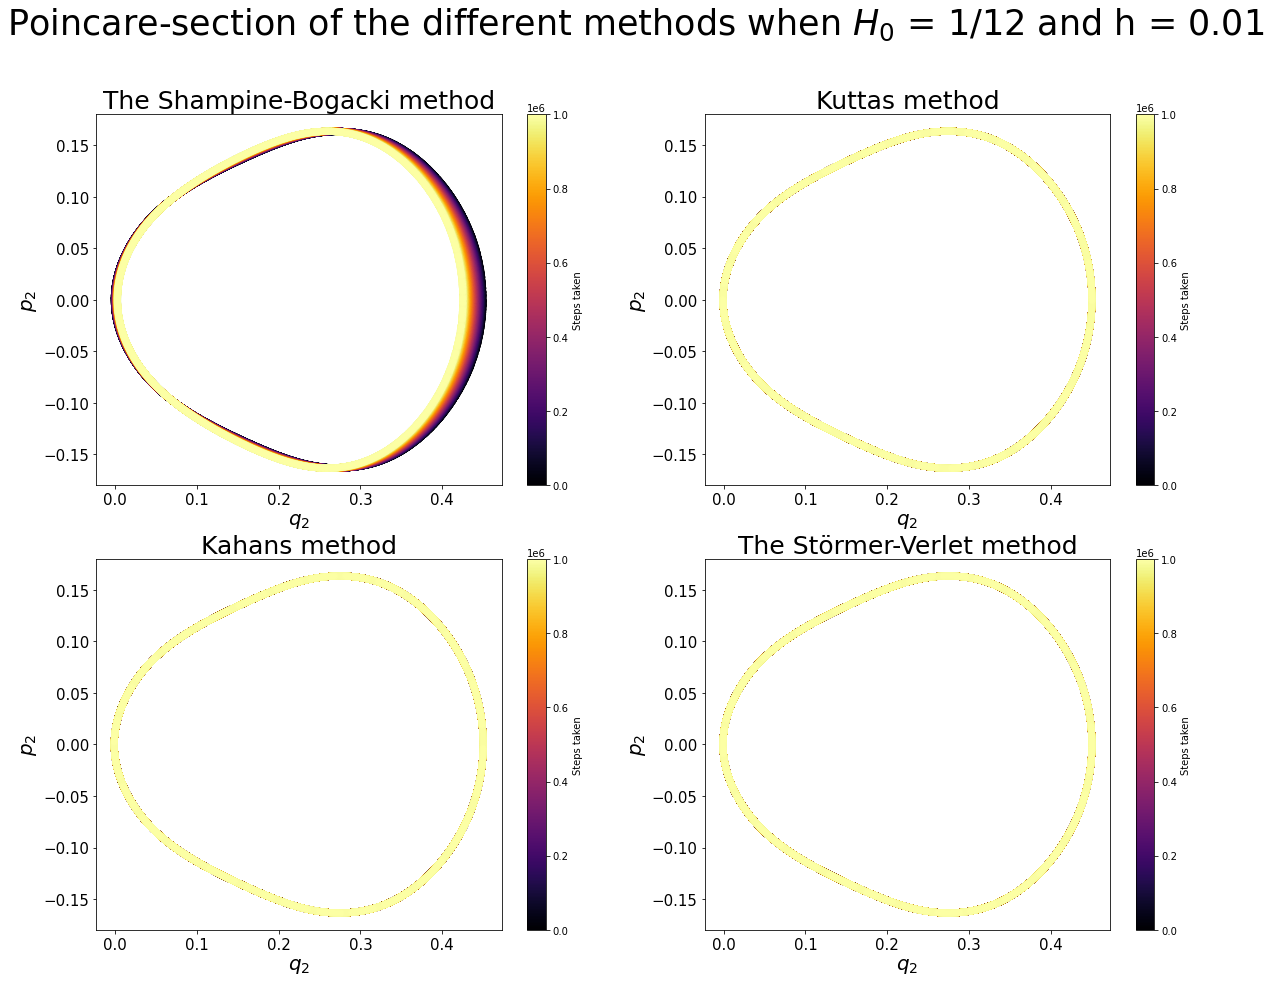

In [26]:
# Here the Poincare-sections are plotted for the different methods.
# First a figur is made and we specify that we want four subplots in a square. 
# Then the figure is given a title. 
# Since the plotcode for the different methods are identical they will be commented once.
# First the subplot is given a title. Then p_2_lst is plotted as a function of q_2_lst.
# The axes are then given titles and the fontsize on the axes is set. 
# In the end a plt.show makes sure the figure is given as output. 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

fig.suptitle('Poincare-section of the different methods when $H_0$ = 1/12 and h = 0.01', fontsize=35)

ax1.set_title("The Shampine-Bogacki method", fontsize=25)
im1 = ax1.scatter(q_2_lst_A, p_2_lst_A, c = t_lst_A, cmap= "inferno")
fig.colorbar(im1, ax=ax1, label = "Steps taken")
ax1.set_ylabel('$p_2$', fontsize=20)
ax1.set_xlabel('$q_2$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.set_title("Kuttas method", fontsize=25)
im2 = ax2.scatter(q_2_lst_B, p_2_lst_B, c = t_lst_B, cmap= "inferno")
fig.colorbar(im2, ax=ax2, label = "Steps taken")
ax2.set_ylabel('$p_2$', fontsize=20)
ax2.set_xlabel('$q_2$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)


ax3.set_title("Kahans method", fontsize=25)
im3 = ax3.scatter(q_2_lst_C, p_2_lst_C, c = t_lst_C, cmap= "inferno")
fig.colorbar(im3, ax=ax3, label = "Steps taken")
ax3.set_ylabel('$p_2$', fontsize=20)
ax3.set_xlabel('$q_2$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)


ax4.set_title(u"The St\xF6rmer-Verlet method", fontsize=25)
im4 = ax4.scatter(q_2_lst_D, p_2_lst_D, c = t_lst_D, cmap= "inferno")
fig.colorbar(im4, ax=ax4, label = "Steps taken")
ax4.set_ylabel('$p_2$', fontsize=20)
ax4.set_xlabel('$q_2$', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=15)


plt.show()

The plots above shows the Poincarè-maps using the different kinds of methods when $H_0 =\frac{1}{12}$, which is expected to look like this - a closed and smooth curve - according to the project description and the reference [1] (p.16). 

First, we can see a drift for the Shampine-Bogacki method, but not the others. If we take into account our results in problem 2 this is as expected. The Störmer-Verlet method is symplectic, and therefore we expect the crosspoints to stay on the curve even for long periods of time. The same behaviour is expected for Kahans method because of the perturbing of the model. For Kuttas method one might expect a drift if the simulation is run a very long period of time, due to the very small loss of energy with time. Since Kuttas method are better at preserving energy than Shampine-Bogacki the Poincarè map for Shampine-Bogacki should show signs of drift earlier than Kuttas method just as we get here. So here the convergence order of the method makes a significant difference. Unfortunately, our computers were not capable of running the simulation for a larger time interval $T$ than $T = 10^7$. We ran the simulation one time for $T = 10^7$ to see if Kuttas methods would drift like the Shampine-Bogacki method. The result for the same simulation as above, but with $T=10^7$, is given in the figures below, and here we did not get a drift in the Poincarè-map for Kutta. Therefore, we instead tried to increase the step lenght as shown below in the next plot.



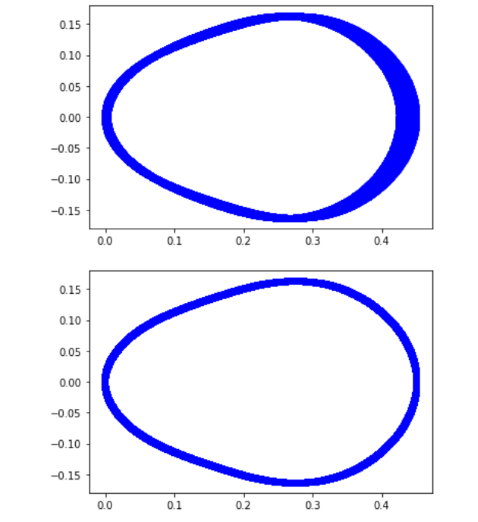
<div style="text-align: right"> (figure 1) </div>


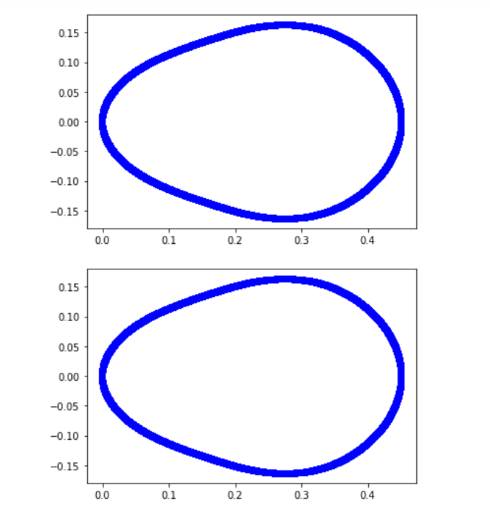

<div style="text-align: right"> (figure 2) </div>

The first plot is of the Shampine-Bogacki method, the second plot is of Kuttas method, the third plot is of Kahans method and the last plot is of the Störmer-Verlet method when $T= 10^7$ and $h = 0.01$ and the other initial values as the simulation above.

In [27]:
# Here variables for this problem are defined. 
H_0 = 1/12
t_0 = 0
p1 = p_1_calc(0.0, 0.45,0, H_0)
y_0=[0.0,0.45,p1,0.0]

T=1e6 
h=1e-1

# Here the Poincarè function is called for all the methods
q_2_lst_A, p_2_lst_A = solve_HH_A_Poincarè(t_0, T,h,y_0)
q_2_lst_B, p_2_lst_B = solve_HH_B_Poincarè(t_0, T,h,y_0)
q_2_lst_C, p_2_lst_C = solve_HH_C_Poincarè(t_0, T,h,y_0)
q_2_lst_D, p_2_lst_D = solve_HH_D_Poincarè(t_0, T,h,y_0)

t_lst_A = t_lst_func(t_0,T,len(q_2_lst_A))
t_lst_B = t_lst_func(t_0,T,len(q_2_lst_B))
t_lst_C = t_lst_func(t_0,T,len(q_2_lst_C))
t_lst_D = t_lst_func(t_0,T,len(q_2_lst_D))

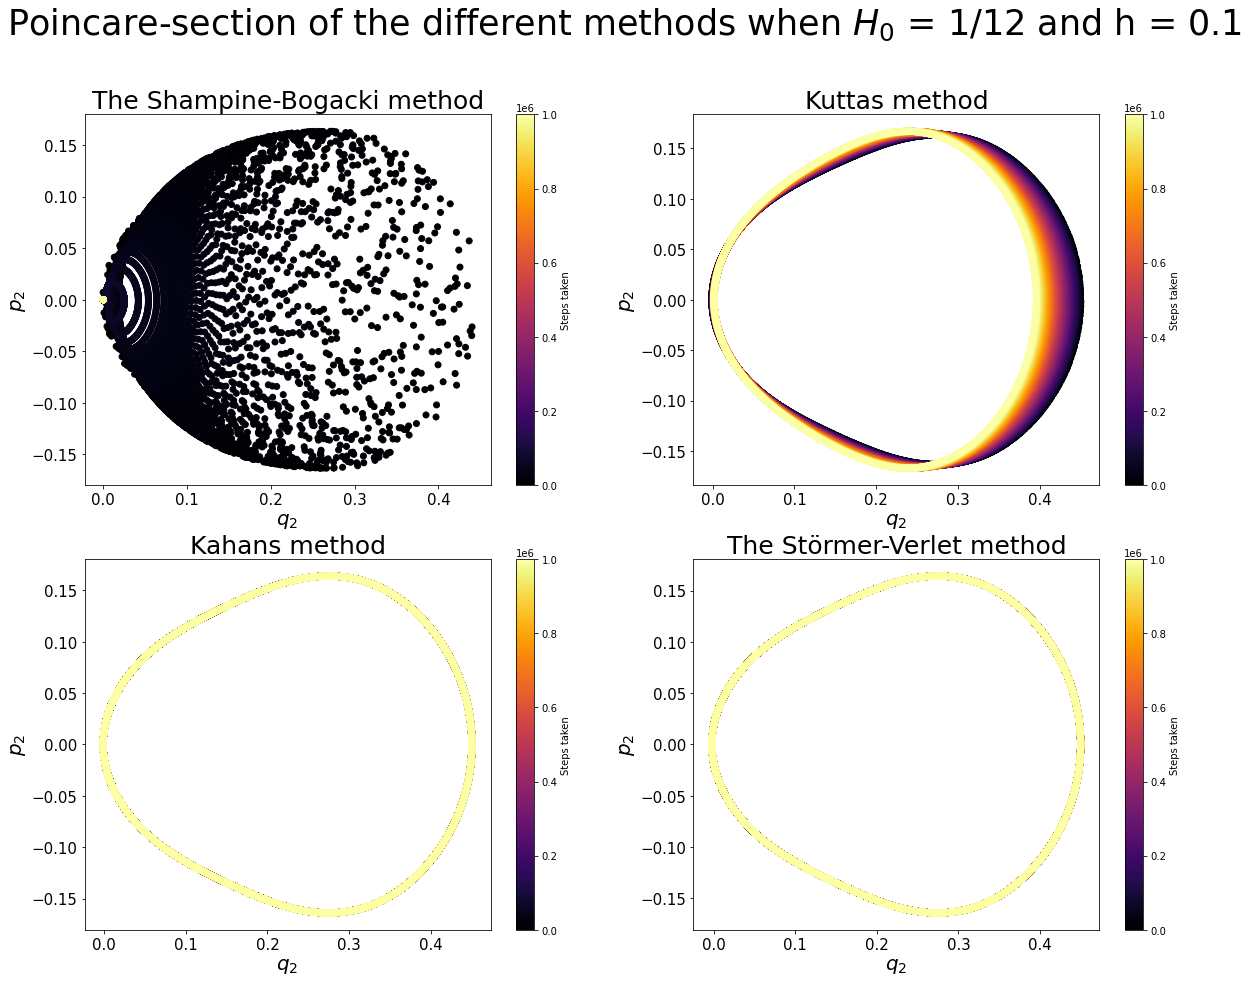

In [28]:
# Here the Poincare-sections are plotted for the different methods.
# First a figur is made and we specify that we want four subplots in a square. 
# Then the figure is given a title. 
# Since the plotcode for the different methods are identical they will be commented once.
# First the subplot is given a title. Then p_2_lst is plotted as a function of q_2_lst.
# The axes are then given titles and the fontsize on the axes is set. 
# In the end a plt.show makes sure the figure is given as output. 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

fig.suptitle('Poincare-section of the different methods when $H_0$ = 1/12 and h = 0.1', fontsize=35)

ax1.set_title("The Shampine-Bogacki method", fontsize=25)
im1 = ax1.scatter(q_2_lst_A, p_2_lst_A, c = t_lst_A, cmap= "inferno")
fig.colorbar(im1, ax=ax1, label = "Steps taken")
ax1.set_ylabel('$p_2$', fontsize=20)
ax1.set_xlabel('$q_2$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.set_title("Kuttas method", fontsize=25)
im2 = ax2.scatter(q_2_lst_B, p_2_lst_B, c = t_lst_B, cmap= "inferno")
fig.colorbar(im2, ax=ax2, label = "Steps taken")
ax2.set_ylabel('$p_2$', fontsize=20)
ax2.set_xlabel('$q_2$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)


ax3.set_title("Kahans method", fontsize=25)
im3 = ax3.scatter(q_2_lst_C, p_2_lst_C, c = t_lst_C, cmap= "inferno")
fig.colorbar(im3, ax=ax3, label = "Steps taken")
ax3.set_ylabel('$p_2$', fontsize=20)
ax3.set_xlabel('$q_2$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)


ax4.set_title(u"The St\xF6rmer-Verlet method", fontsize=25)
im4 = ax4.scatter(q_2_lst_D, p_2_lst_D, c = t_lst_D, cmap= "inferno")
fig.colorbar(im4, ax=ax4, label = "Steps taken")
ax4.set_ylabel('$p_2$', fontsize=20)
ax4.set_xlabel('$q_2$', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=15)


plt.show()

Now, we have increased the step length $h$ to $h=0.1$, and we see that the Poncare-map for Kuttas method drifts. Notice that for Kahans metod and the The Störmer-Verlet method still follows the curve and is not affected, as far as we can see, by the increase in $h$.

In [8]:
# Here variables for this problem are defined. 
H_0 = 1/8
t_0 = 0
p1 = p_1_calc(0.0, 0.45,0, H_0)
y_0=[0.0,0.45,p1,0.0]

T=1e6 
h=1e-1

# Here the Poincarè function is called for all the methods
q_2_lst_A, p_2_lst_A = solve_HH_A_Poincarè(t_0, T,h,y_0)
q_2_lst_B, p_2_lst_B = solve_HH_B_Poincarè(t_0, T,h,y_0)
q_2_lst_C, p_2_lst_C = solve_HH_C_Poincarè(t_0, T,h,y_0)
q_2_lst_D, p_2_lst_D = solve_HH_D_Poincarè(t_0, T,h,y_0)

t_lst_A = t_lst_func(t_0,T,len(q_2_lst_A))
t_lst_B = t_lst_func(t_0,T,len(q_2_lst_B))
t_lst_C = t_lst_func(t_0,T,len(q_2_lst_C))
t_lst_D = t_lst_func(t_0,T,len(q_2_lst_D))

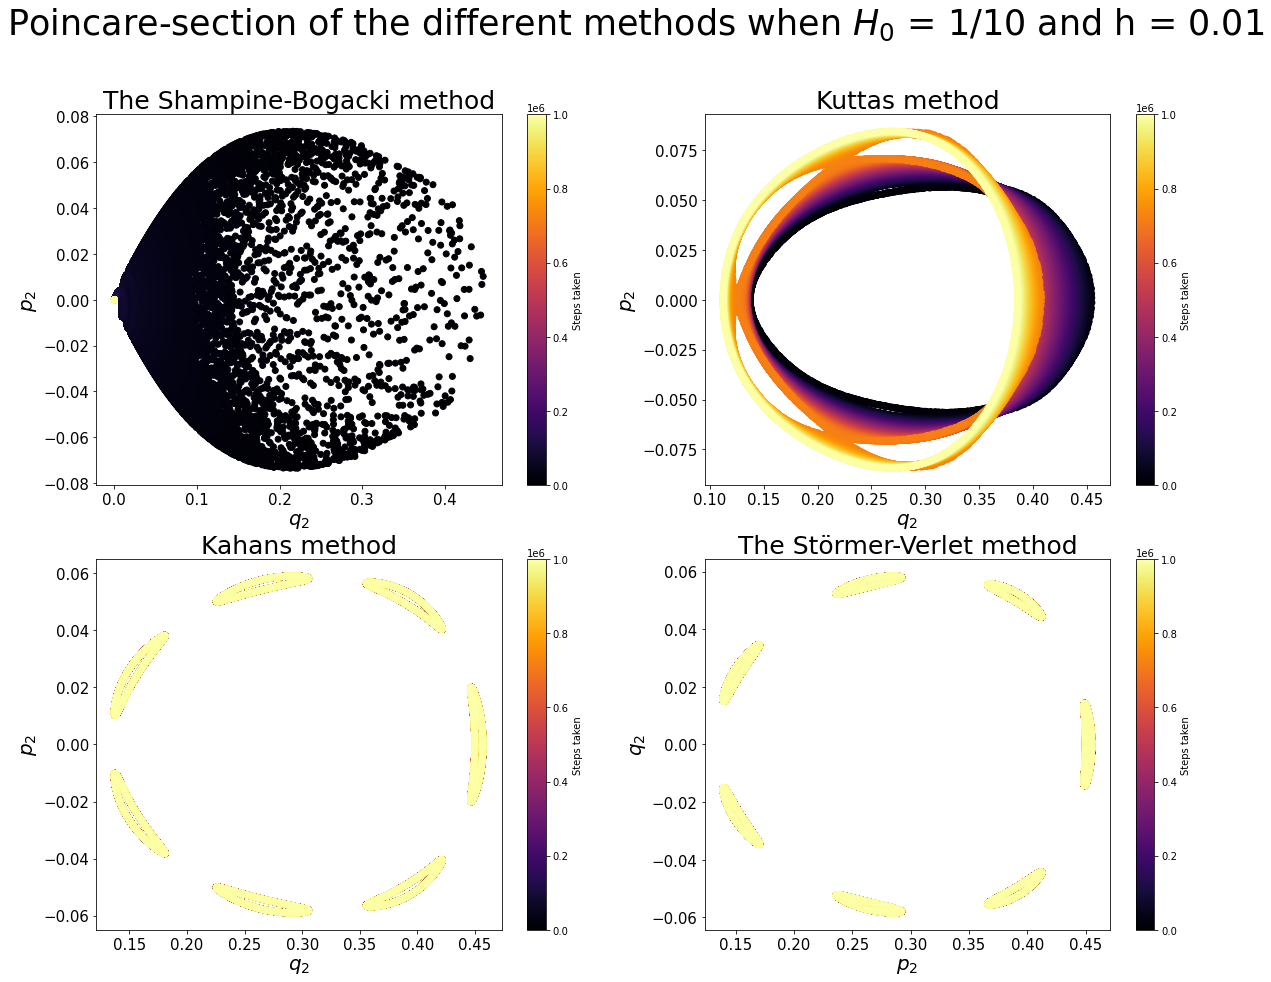

In [9]:
# Here the Poincare-sections are plotted for the different methods.
# First a figur is made and we specify that we want four subplots in a square. 
# Then the figure is given a title. 
# Since the plotcode for the different methods are identical they will be commented once.
# First the subplot is given a title. Then p_2_lst is plotted as a function of q_2_lst.
# The axes are then given titles and the fontsize on the axes is set. 
# In the end a plt.show makes sure the figure is given as output. 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

fig.suptitle('Poincare-section of the different methods when $H_0$ = 1/10 and h = 0.01', fontsize=35)

ax1.set_title("The Shampine-Bogacki method", fontsize=25)
im1 = ax1.scatter(q_2_lst_A, p_2_lst_A, c = t_lst_A, cmap= "inferno")
fig.colorbar(im1, ax=ax1, label = "Steps taken")
ax1.set_ylabel('$p_2$', fontsize=20)
ax1.set_xlabel('$q_2$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.set_title("Kuttas method", fontsize=25)
im2 = ax2.scatter(q_2_lst_B, p_2_lst_B, c = t_lst_B, cmap= "inferno")
fig.colorbar(im2, ax=ax2, label = "Steps taken")
ax2.set_ylabel('$p_2$', fontsize=20)
ax2.set_xlabel('$q_2$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)


ax3.set_title("Kahans method", fontsize=25)
im3 = ax3.scatter(q_2_lst_C, p_2_lst_C, c = t_lst_C, cmap= "inferno")
fig.colorbar(im3, ax=ax3, label = "Steps taken")
ax3.set_ylabel('$p_2$', fontsize=20)
ax3.set_xlabel('$q_2$', fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=15)


ax4.set_title(u"The St\xF6rmer-Verlet method", fontsize=25)
im4 = ax4.scatter(q_2_lst_D, p_2_lst_D, c = t_lst_D, cmap= "inferno")
fig.colorbar(im4, ax=ax4, label = "Steps taken")
ax4.set_ylabel('$q_2$', fontsize=20)
ax4.set_xlabel('$p_2$', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=15)


plt.show()

## Conclusion ##

In this project we have looked at different properties of four different numerical methods applied on the Heénon-Heiles model. We have verified the convergence order of the four methods, as seen by the results in problem 1. In problem 2 we looked at the methods ability to preserve energy. We concluded that neither the Shampine-Bogacki method or Kuttas method are energy preserving, although Kuttas method is way better at preserving energy than Shanpine-Bogacki due to its higher order. For long time intervals Kahans method and the Störmer-Verlet method are energy preserving, but for different reasons. The Störmer-Verlet method beacuse its a symplectic method and thereby preserves the energy of a slightly perturbed Hénon-Heiles model, and therefore oscillates around an $H_0$ close to the actual $H_0$. Kahans method is not symplectic but it preserves the energy of a different model, and therefore the energy oscillates around a $H_0$ farther away form the actual $H_0$. The conclusion of the comparison between the Runge-Kutta methods and the two others are dependent on the time intervall.

Latsly we looked at the Poincaré maps of the different mmethods. For $H_0=\frac{1}{12}$ and $h=0.01$ we got smooth closed curves, with a drift for the Shampine-Bogacki method. This result was expected given our results in problem 2. When we change $h$ to $0.1$ we can also observe a drift for Kuttas method. We have also looked at how different values for $H_0$ affects the Poincaré maps. 

## Sources##

[1] E. Hairer, Ch. Lubich, and G. Wanner. Geometric numerical integration, volume 31 of Springer Series in Computational Mathematics. Springer, Heidelberg,2010. Structure-preserving algorithms for ordinary differential equations, Reprint ofthe second (2006) edition.

[2] E.Celldoni, R.I.McLachlan, B.Owren, G.R.W. Quispel. Geometric properties of Kahan's method, 14. november 2012. https://arxiv.org/pdf/1209.1164.pdf, downloaded 18.04.2021

[3] G.Zhong, J.E.Marsden. Lie-Poisson Hamilton-Jacobi theory and Lie-Poisson integrators. Physics Letters A, volume 133, number 3, 7.november 1988, http://www.cds.caltech.edu/~marsden/bib/1988/04-GeMa1988/GeMa1988.pdf, downloaded 18.04.2021